In [3]:
from urllib.request import urlopen
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
# 시계열데이터 import
sma_train = pd.read_csv("meteorological/timeseries_data/sma_train.csv",index_col=0, parse_dates=True)
sma_train.index.freq = '5T'
ses_train = pd.read_csv("meteorological/timeseries_data/ses_train.csv",index_col=0, parse_dates=True)
ses_train.index.freq = '5T'
des_train = pd.read_csv("meteorological/timeseries_data/des_train.csv",index_col=0, parse_dates=True)
des_train.index.freq = '5T'
tes_tr_add = pd.read_csv("meteorological/timeseries_data/tes_tr_add.csv",index_col=0, parse_dates=True)
tes_tr_add.index.freq = '5T'
tes_tr_mul = pd.read_csv("meteorological/timeseries_data/tes_tr_mul.csv",index_col=0, parse_dates=True)
tes_tr_mul.index.freq = '5T'
# 기상데이터 import
df_final = pd.read_csv("meteorological/df_final.csv", index_col=0, parse_dates=True) # 기상데이터 total 최종본
df_final.index.freq = '5T'
train = pd.read_csv("meteorological/train.csv", index_col=0, parse_dates=True) # 2022-04-01 00:00:00 ~ 2023-03-12 23:55:00 까지의 데이터
train.index.freq = '5T'
X_train = pd.read_csv("meteorological/X_train.csv", index_col=0, parse_dates=True)
X_train.index.freq='5T'
y_train = pd.read_csv("meteorological/y_train.csv", index_col=0, parse_dates=True)
y_train.index.freq='5T'
test = pd.read_csv("meteorological/test.csv", index_col=0, parse_dates=True) # 2023-03-13 00:00:00':'2023-03-19 23:55:00' 까지의 데이터
test.index.freq = '5T'
X_test = pd.read_csv("meteorological/X_test.csv", index_col=0, parse_dates=True)
X_test.index.freq = '5T'
y = pd.read_csv("meteorological/y.csv", index_col=0, parse_dates=True)
y.index.freq = '5T'

NameError: name 'pd' is not defined

# Traditional Timeseries Features

## Linear Interpolate

In [4]:

def lin_inter(df):
    # 5분 간격으로 리샘플링
    df_resampled = df.resample('5T').mean()
    # NaN 값들을 선형적으로 보간
    df_resampled = df_resampled.interpolate(method='linear')
    return df_resampled

In [5]:

def find_duplicate_index(df):
    duplicate_index = df.index[df.index.duplicated()]
    return duplicate_index

# 중복된 인덱스 값을 찾습니다.
duplicate_index = find_duplicate_index(df_final)

# 결과 출력
print("Duplicate Indices:", duplicate_index)


Duplicate Indices: DatetimeIndex([], dtype='datetime64[ns]', freq='5T')


## Statistics

### PCF, APCF

In [6]:
dfY = pd.concat([y_train, y])
dfY.tail()

현재수요(MW)
2023-03-19 23:35:00  58627.16
2023-03-19 23:40:00  57941.24
2023-03-19 23:45:00  57726.21
2023-03-19 23:50:00  57755.40
2023-03-19 23:55:00  57323.79

In [7]:
dfY.describe()

현재수요(MW)
count  101664.000000
mean    65589.808847
std      9548.243139
min     41872.380000
25%     58471.420000
50%     64738.390000
75%     71484.135000
max     94852.870000

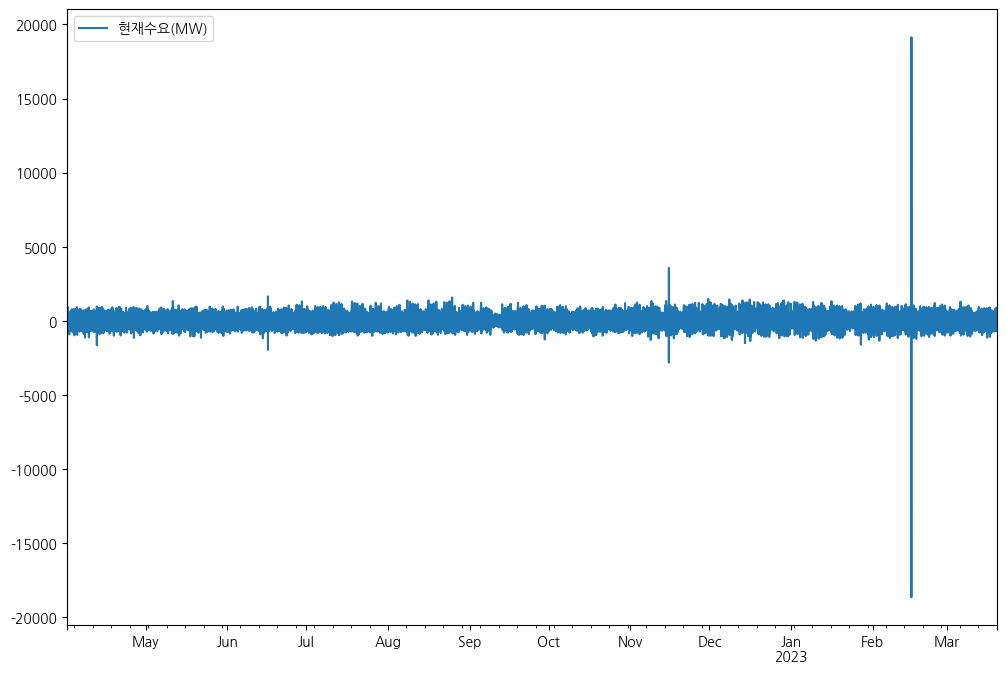

In [8]:
from statsmodels.tsa.statespace.tools import diff
diff(dfY, k_diff=1).plot(figsize=(12,8));

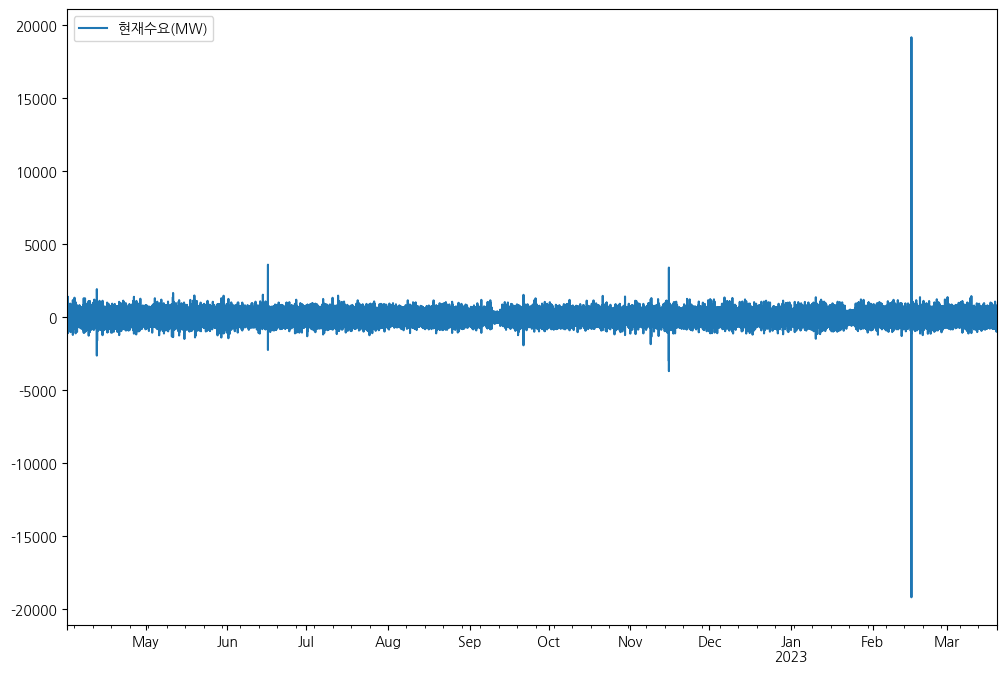

In [9]:
diff(dfY, k_diff=2).plot(figsize=(12,8));

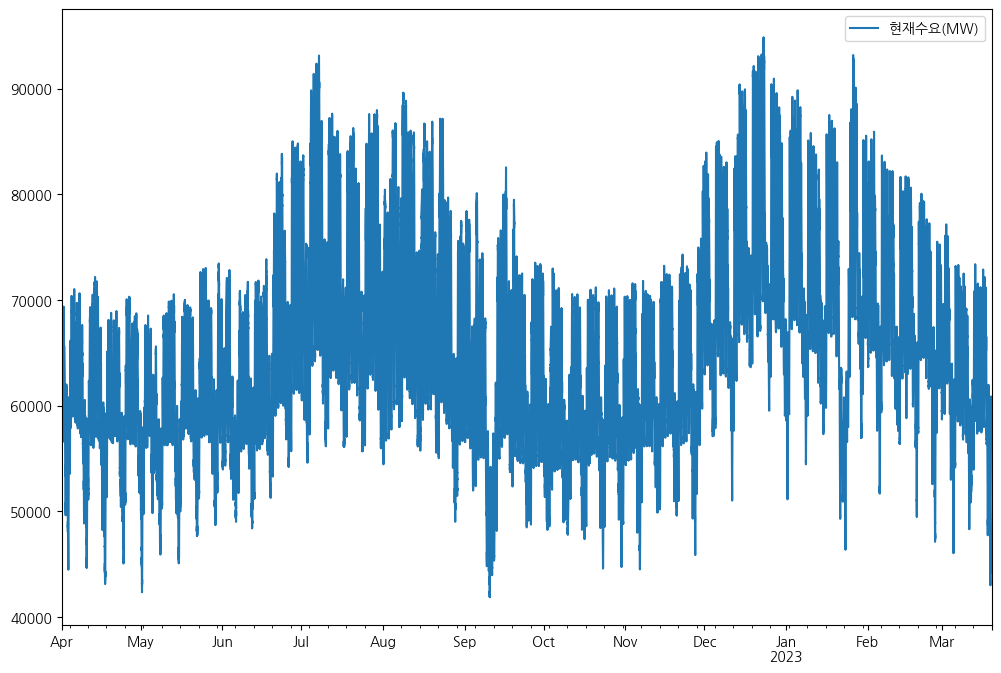

In [10]:
dfY.plot(figsize=(12,8));

In [11]:
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
import warnings
warnings.filterwarnings("ignore")

In [12]:
pacf_yw(dfY, nlags=288, method='mle')

array([ 1.00000000e+00,  9.99514620e-01, -3.91985794e-01, -2.98840513e-01,
       -1.37117007e-01, -1.72689662e-01, -1.55895947e-01, -1.17145413e-01,
       -4.15169463e-02, -3.28908458e-02, -7.23716068e-02, -3.55485655e-02,
       -2.25443972e-02, -5.42614949e-02,  1.03002161e-02,  3.16637921e-02,
        2.29840162e-02,  1.17962196e-02,  9.21301178e-04, -2.09373866e-02,
        5.94837410e-03, -3.06511484e-04, -1.03734952e-02, -2.60599192e-02,
       -2.72567962e-02, -3.46531545e-02, -2.03191698e-02, -2.04178998e-02,
       -8.84001972e-03,  2.94786526e-03,  9.21809854e-03,  7.99391446e-03,
        1.75361518e-02,  2.27763935e-02,  1.30596499e-02,  1.15243605e-02,
        1.42734548e-02,  1.64250198e-02,  2.67143684e-02,  3.10029241e-02,
        3.56454883e-02,  4.57759126e-02,  4.31458971e-02,  2.99761246e-02,
        2.36129522e-02,  8.03097248e-03,  1.14427776e-02,  2.23095253e-02,
        2.54563010e-02,  4.93424364e-03, -1.24807127e-03, -2.37242248e-02,
       -2.51253101e-02, -

In [13]:
pacf_ols(dfY, nlags=288)

array([ 1.00000000e+00,  9.99521988e-01, -3.95781536e-01, -3.00344279e-01,
       -1.37177511e-01, -1.74189557e-01, -1.56641672e-01, -1.17407518e-01,
       -4.04174315e-02, -3.18811911e-02, -7.32984226e-02, -3.47878669e-02,
       -2.05582036e-02, -5.49940200e-02,  1.07207455e-02,  3.28783975e-02,
        2.32678251e-02,  1.14151187e-02,  1.20086046e-03, -2.10736597e-02,
        4.92438386e-03,  8.31452971e-05, -1.08667378e-02, -2.61381389e-02,
       -2.71151868e-02, -3.49207466e-02, -2.01797395e-02, -2.05349989e-02,
       -8.98491177e-03,  3.54971312e-03,  9.39624013e-03,  8.64117532e-03,
        1.83743979e-02,  2.27956898e-02,  1.29121162e-02,  1.15602901e-02,
        1.40650342e-02,  1.64422133e-02,  2.67484965e-02,  3.11499315e-02,
        3.60426716e-02,  4.57372495e-02,  4.32510157e-02,  2.99958221e-02,
        2.42955596e-02,  7.63277167e-03,  1.09520686e-02,  2.24422596e-02,
        2.56614717e-02,  4.74524621e-03, -1.20670005e-03, -2.48510110e-02,
       -2.55962195e-02, -

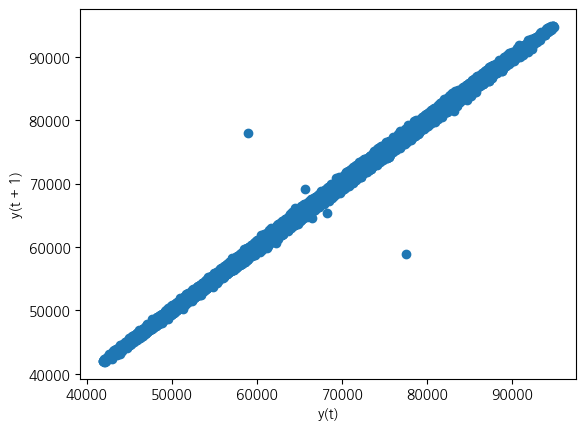

In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import lag_plot

lag_plot(dfY); # 강한 자기상관관계

In [14]:
# # 가장 유효한 시점(13시간, 24시간 ,48시간)
# feature_target_list = [156, 288, 576]

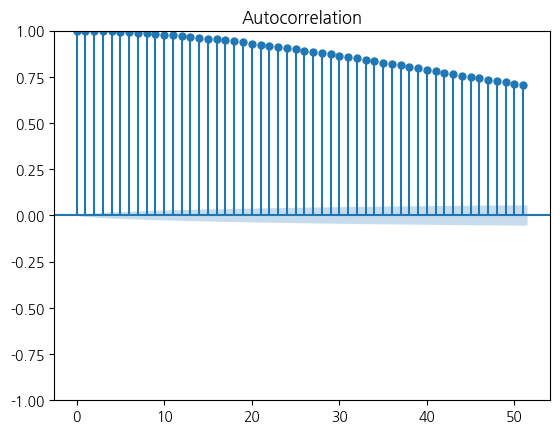

In [15]:
plot_acf(dfY);

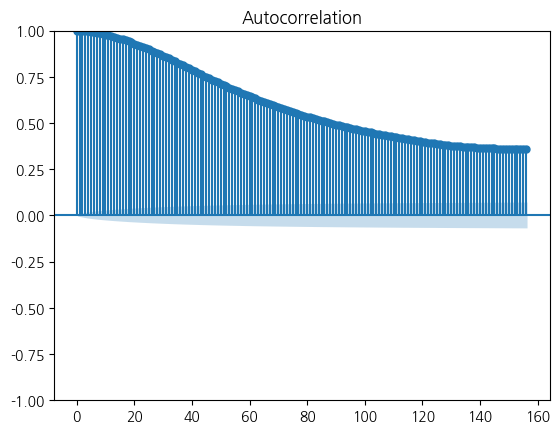

In [16]:
plot_acf(dfY,lags= 156);

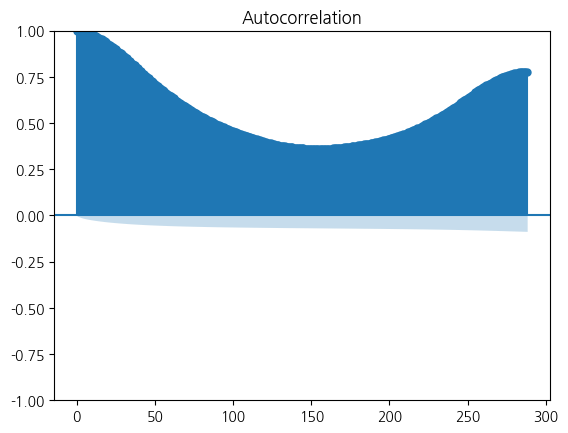

In [178]:
plot_acf(dfY,lags= 288);

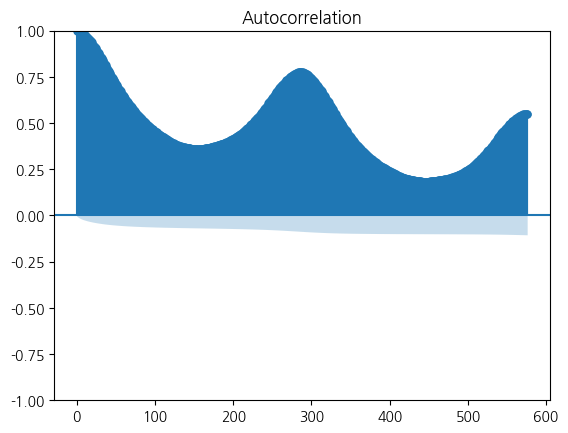

In [179]:
plot_acf(dfY,lags= 576);

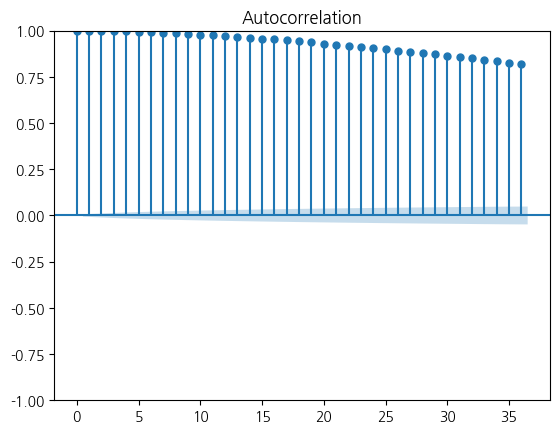

In [180]:
plot_acf(dfY,lags= 36);

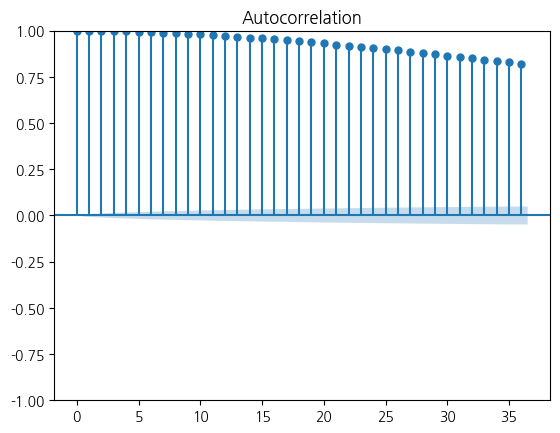

In [181]:
plot_acf(y_train,lags= 36);

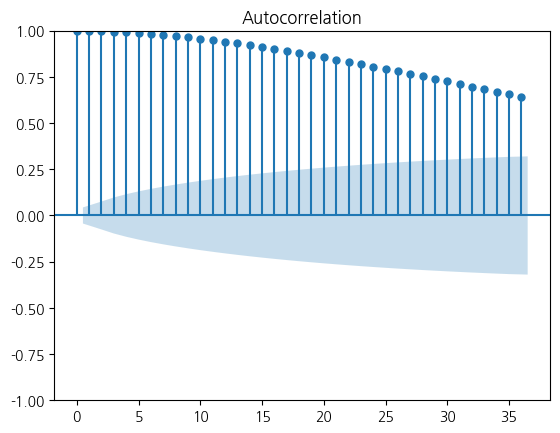

In [182]:
plot_acf(y,lags= 36);

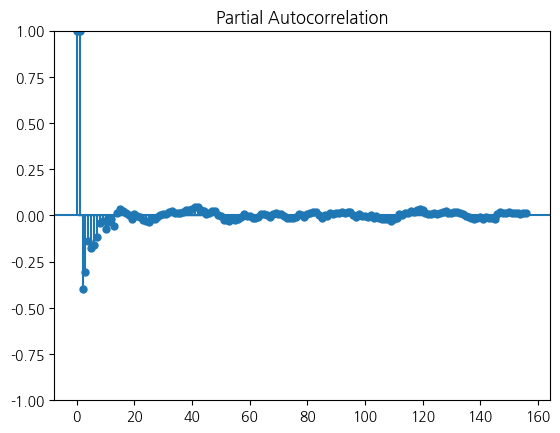

In [183]:
plot_pacf(dfY,lags=156);

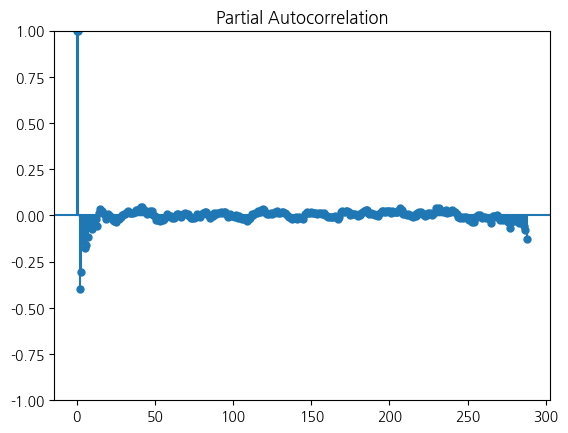

In [184]:
plot_pacf(dfY,lags=288);

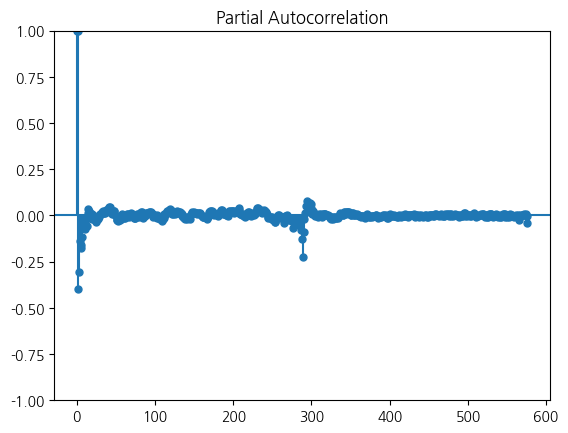

In [185]:
plot_pacf(dfY,lags=576);

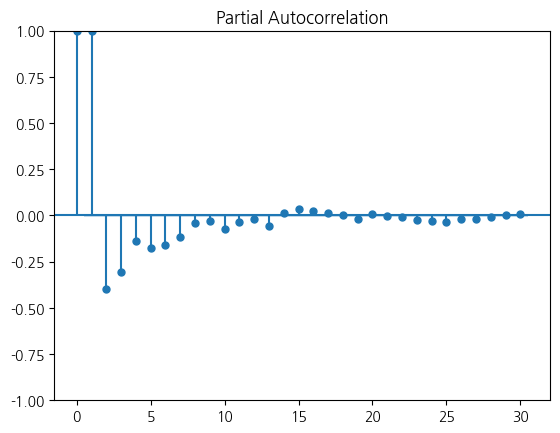

In [186]:
plot_pacf(dfY,lags=30);

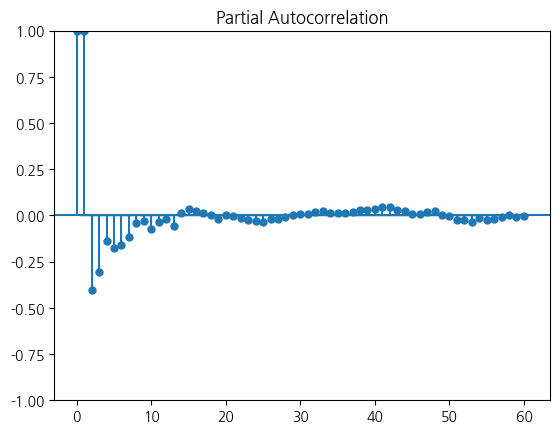

In [187]:
plot_pacf(y_train,lags=60);

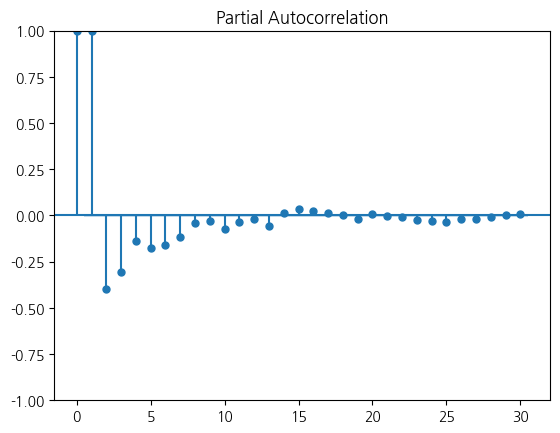

In [188]:
plot_pacf(dfY,lags=30);
# sharp drop after lag "k" == 2

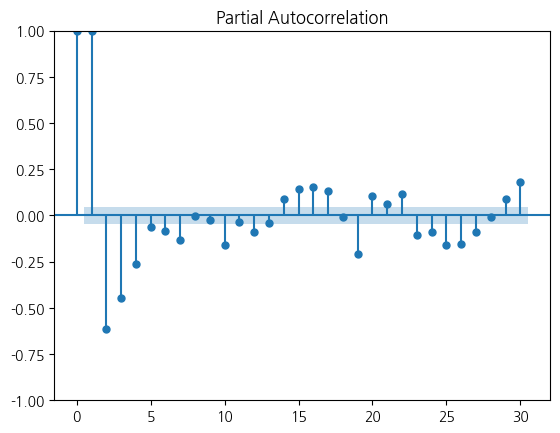

In [189]:
plot_pacf(y,lags=30);
# sharp drop after lag "k" == 2 ~ ?

In [190]:
arr = acovf(dfY)
pd.Series(arr).describe()

count    1.016640e+05
mean     4.483792e+02
std      1.505634e+07
min     -3.882564e+07
25%     -7.963158e+06
50%     -2.919188e+05
75%      6.131732e+06
max      9.116805e+07
dtype: float64

In [191]:
pd.Series(arr).tail()

101659    1396.639629
101660    1098.275500
101661     799.492372
101662     506.812755
101663     255.021678
dtype: float64

In [192]:
pd.Series(arr).head()

0    9.116805e+07
1    9.112380e+07
2    9.104489e+07
3    9.093006e+07
4    9.078575e+07
dtype: float64

In [193]:
arr2 = acovf(dfY, adjusted=True)
pd.Series(arr2).tail()

101659    2.839759e+07
101660    2.791377e+07
101661    2.709320e+07
101662    2.576231e+07
101663    2.592652e+07
dtype: float64

In [194]:
arr3 = acf(dfY)
arr3

array([1.        , 0.99951462, 0.99864904, 0.99738955, 0.99580663,
       0.99386776, 0.99157138, 0.98892437, 0.98597338, 0.9827333 ,
       0.9791881 , 0.97535739, 0.97125289, 0.96686691, 0.96224433,
       0.95740873, 0.95237536, 0.94715089, 0.94173953, 0.93613675,
       0.93037154, 0.9244511 , 0.91837783, 0.91214587, 0.90575763,
       0.89921059, 0.89251991, 0.88568809, 0.87872375, 0.87163665,
       0.86443678, 0.85712936, 0.84972941, 0.84224877, 0.83469065,
       0.82706125, 0.81936893, 0.81162447, 0.80384764, 0.79605387,
       0.78825942, 0.78048527, 0.77274702, 0.7650522 , 0.7574107 ,
       0.74982361, 0.74230199, 0.73486147, 0.72751513, 0.72025928,
       0.71309688])

In [195]:
acf_pacf_features = [156, 288, 576]
'''
AR 모델의 차수는 2 이상
'''

'\nAR 모델의 차수는 2 이상\n'

분석결과 13시간, 24시간 ,48시간의 극대값을 가지는 정상성 데이터, 높은 자기상관계수를 알 수 있었음.
그러나 pacf plot을 통해 단기적으로 비정상성을 확인할 수도 있음 - 계속

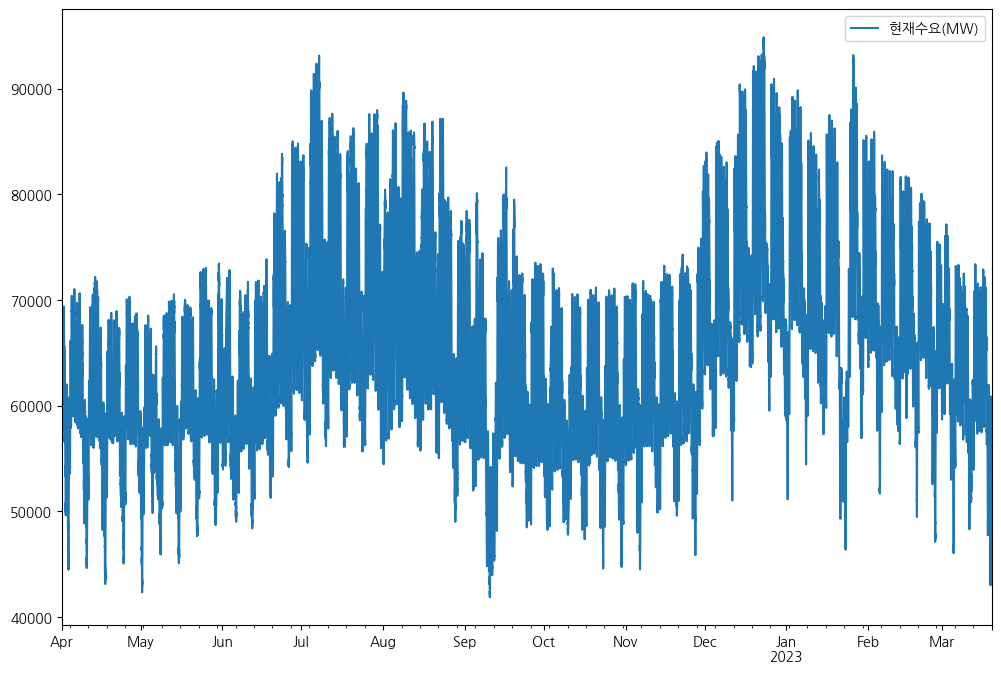

In [34]:
dfY.plot(figsize=(12,8));

### STL

In [196]:
dfY.index

DatetimeIndex(['2022-04-01 00:00:00', '2022-04-01 00:05:00',
               '2022-04-01 00:10:00', '2022-04-01 00:15:00',
               '2022-04-01 00:20:00', '2022-04-01 00:25:00',
               '2022-04-01 00:30:00', '2022-04-01 00:35:00',
               '2022-04-01 00:40:00', '2022-04-01 00:45:00',
               ...
               '2023-03-19 23:10:00', '2023-03-19 23:15:00',
               '2023-03-19 23:20:00', '2023-03-19 23:25:00',
               '2023-03-19 23:30:00', '2023-03-19 23:35:00',
               '2023-03-19 23:40:00', '2023-03-19 23:45:00',
               '2023-03-19 23:50:00', '2023-03-19 23:55:00'],
              dtype='datetime64[ns]', length=101664, freq='5T')

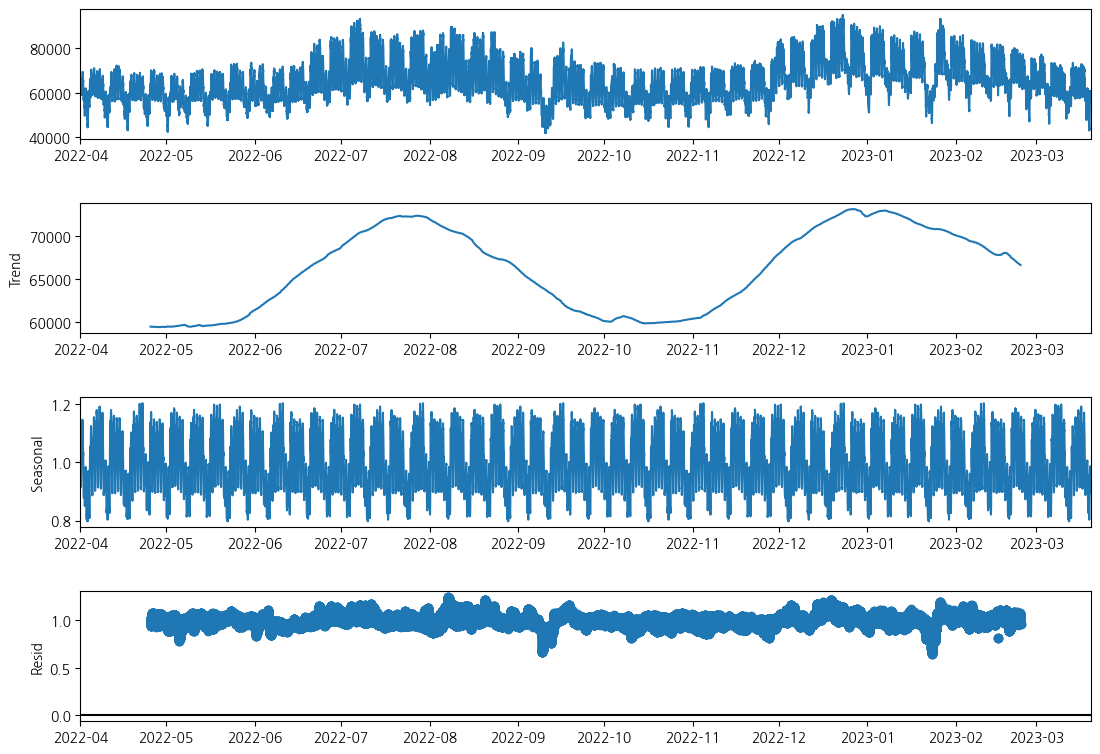

In [197]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dfY, model='mul', period=2016*7)  # 일주일
fig = result.plot()
fig.set_size_inches(12,8);

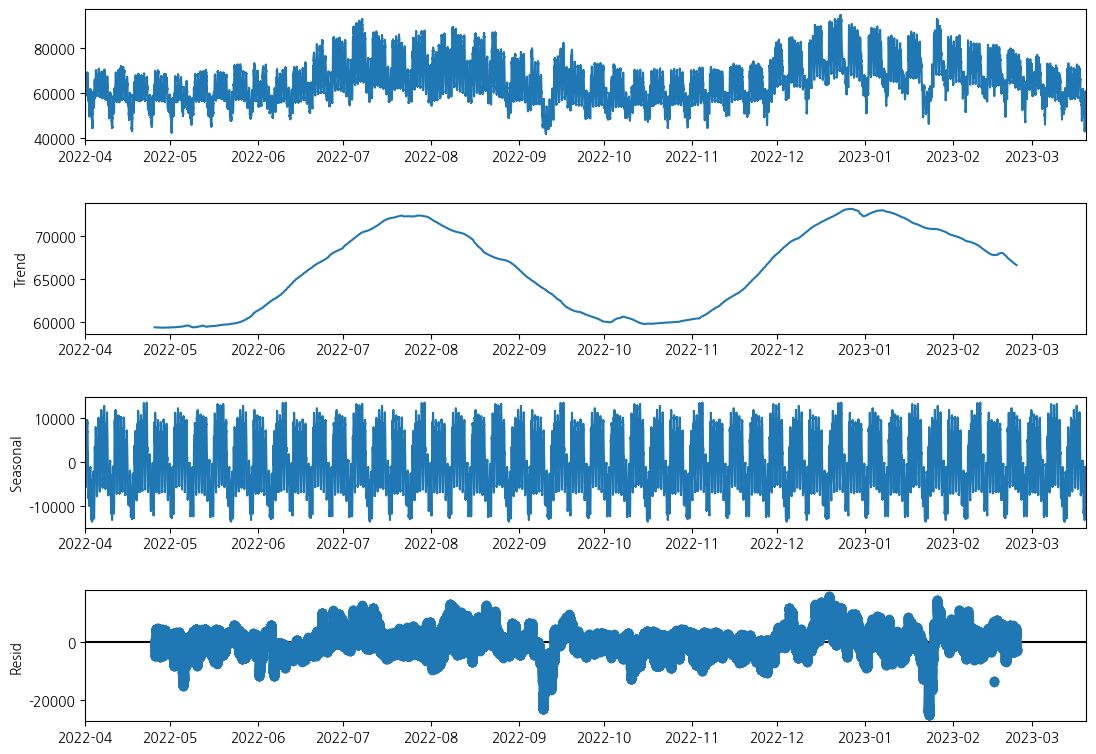

In [198]:


result = seasonal_decompose(dfY, model='add', period=2016*7)  # 일주일
fig = result.plot()
fig.set_size_inches(12,8);

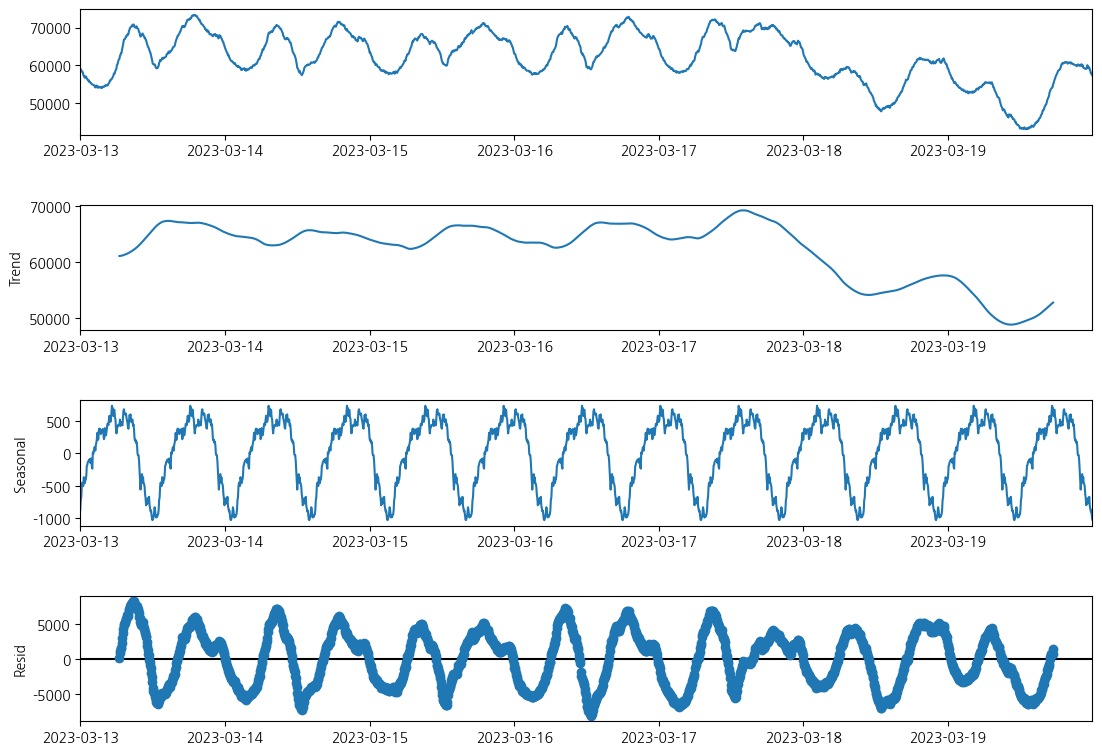

In [199]:


result = seasonal_decompose(y, model='add', period=12*13)  # 13시간(반나절)
fig = result.plot()
fig.set_size_inches(12,8);

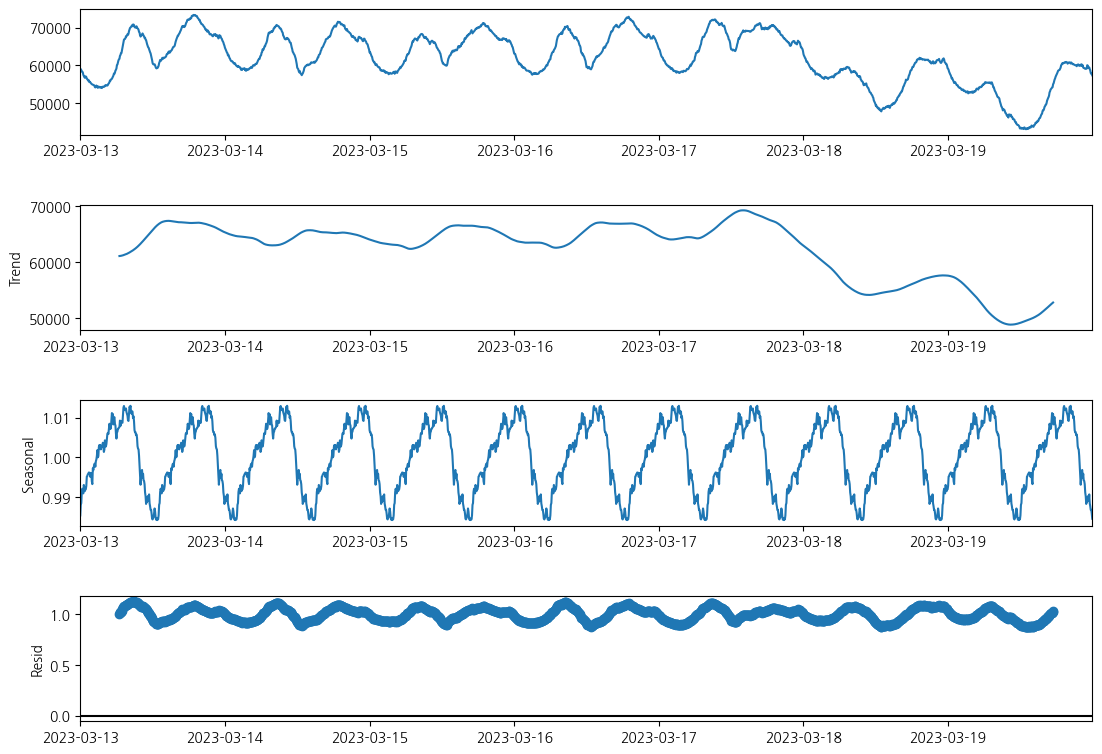

In [200]:
result = seasonal_decompose(y, model='mul', period=12*13)  #  13시간(반나절)
fig = result.plot()
fig.set_size_inches(12,8);

### Dickey-Fuller test


In [40]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [41]:
adf_test(dfY)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.751036e+01
p-value                 4.338274e-30
# lags used             6.800000e+01
# observations          1.015950e+05
critical value (1%)    -3.430414e+00
critical value (5%)    -2.861568e+00
critical value (10%)   -2.566785e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [42]:
adf_test(y_train)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.745442e+01
p-value                 4.633727e-30
# lags used             6.800000e+01
# observations          9.957900e+04
critical value (1%)    -3.430416e+00
critical value (5%)    -2.861569e+00
critical value (10%)   -2.566785e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [43]:
adf_test(y)

Augmented Dickey-Fuller Test: 
ADF test statistic        -4.416332
p-value                    0.000278
# lags used               25.000000
# observations          1990.000000
critical value (1%)       -3.433640
critical value (5%)       -2.862993
critical value (10%)      -2.567544
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [201]:
adf_features = [25, 68]

현재수요(MW)는 정상시계열로 해석할 수 있다.

## ARMA, ARIMA

In [189]:
# !pip install pmdarima

     ------------------------------------- 572.7/572.7 kB 18.1 MB/s eta 0:00:00
     ------------------------------------- 988.3/988.3 kB 30.6 MB/s eta 0:00:00


In [3]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [64]:
help(auto_arima)

[144, 288, 576, 864, 1152, 1440, 1728, 2016]

### Grid Search - 밤에 돌리고 잘것

In [202]:
# compare day values
day = 288
half = day/2
target_time = [int(half), 1*day, 2*day, 3*day, 4*day, 5*day, 6*day, 7*day]
target_time

[144, 288, 576, 864, 1152, 1440, 1728, 2016]

In [203]:
# compare hour values
hour = 12
target_time_h = [i * hour for i in range(1,25)]
target_time_h

[12,
 24,
 36,
 48,
 60,
 72,
 84,
 96,
 108,
 120,
 132,
 144,
 156,
 168,
 180,
 192,
 204,
 216,
 228,
 240,
 252,
 264,
 276,
 288]

In [204]:
total_t = target_time + target_time_h
total_t.sort()
total_t

[12,
 24,
 36,
 48,
 60,
 72,
 84,
 96,
 108,
 120,
 132,
 144,
 144,
 156,
 168,
 180,
 192,
 204,
 216,
 228,
 240,
 252,
 264,
 276,
 288,
 288,
 576,
 864,
 1152,
 1440,
 1728,
 2016]

In [205]:
temp = [864, 1152, 1440, 1728, 2016]

In [208]:
arma_fit = {}
for k in temp:
    arma_fit[f'{k}'] = auto_arima(y_train
                                ,m = k

                              # ,start_d = 2

               ,seasonal= False # 정상성데이터이므로 계절요소 제거
                ,trace=True)
    '''
    arma grid search는 시스템 자원의 한계로 MA의 다양성을 검증하진 못함
    '''
    with open(f'meteorological/model/arima/arma_model_{k}.pkl', 'wb') as pkl:
        pickle.dump(arma_fit[f'{k}'], pkl)
    arma_fit[f'{k}'].summary()

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [209]:

arima_fit = auto_arima(y_train
                            # ,m = k

                          # ,start_d = 2

           ,seasonal= True # 계절요소의 적용 (ARIMA)
            ,trace=True)
'''
arima grid search는 시스템 자원의 한계로 MA의 다양성을 검증하진 못함
'''
with open(f'meteorological/model/arima/arima_mod.pkl', 'wb') as pkl:
    pickle.dump(arima_fit, pkl)
arima_fit.summary()

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [210]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders



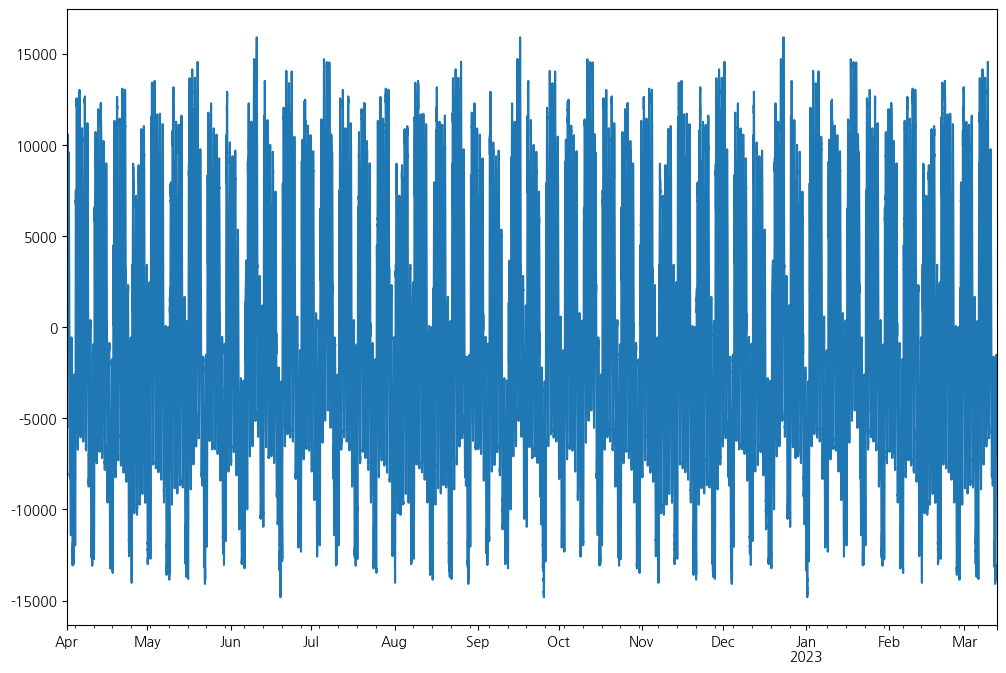

In [211]:
result = seasonal_decompose(y_train, model='add', period = 2016*14)
result.seasonal.plot(figsize=(12,8));

In [214]:
result.iloc[-2016*7:].seasonal.plot(figsize=(12,8));

AttributeError: 'DecomposeResult' object has no attribute 'iloc'

In [213]:
# ARMA 분석에 따른 span 조정할것!
temp = [25, 68, 144, 156, 288, 576, 864, 1152, 1440, 1728, 2016]

In [215]:
# arma = list(set([108, 1152, 12, 120, 132, 144, 1440, 156,168, 1728, 180, 192, 2016,204, 24, 25, 288, 36, 48, 576, 60, 68, 72, 84, 864,96]))
# arma.sort()
# arma

## SARIMAX(기상변수 포함)

In [216]:

# 모델 파일이 저장된 디렉토리
model_dir = 'meteorological/model/sarimax'
start = len(train)
end = len(df_final)
y_pred = {}  # 예측 값
under_20 = {}
# 디렉토리에 있는 모든 파일을 대상으로
for filename in os.listdir(model_dir):
    # '.pkl' 확장자인 파일만 처리
    if filename.endswith('.pkl'):
        # 파일을 불러옴
        with open(os.path.join(model_dir, filename), 'rb') as file:
            model = pickle.load(file)

        # 모델을 사용하여 값을 예측
        # 예측에 필요한 입력 데이터는 해당 모델에 따라 다를 수 있음
        prediction = model.predict(2016).rename(f'{filename}')

        # 예측 값을 y_pred 리스트에 추가
        y_pred[filename] = prediction

        # 모델 이름과 MAPE 값을 출력
        mape_v = mape(y, prediction)
        print(f'MAPE of {filename}: {mape_v*100:.4f}%')
        if mape_v*100 <= 20 and filename[:3] == 'TES' :
            under_20[filename] = mape_v*100
        # mape_v = mean_absolute_error(y, y_pred) / (sum(y)/len(y)) * 100
        # print(f'MAPE of {filename}: {mape_v}%')

### 외생변수 삽입(한개씩)

In [217]:
target_columns = list(train.columns)

In [218]:
# model = SARIMAX(train['total'],exog=train[target_columns],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
# results = model.fit()
# results.summary()

KeyError: 'total'

실험결과 SARIMAX는 컴퓨팅자원의 한계로 수행할 수 없었음

## Vector-AutoRegression(VAR) (Drop - 과대학습 및 선형 forecasting 결과로 drop)

In [122]:
from statsmodels.tsa.api import VAR #, DynamicVAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

In [120]:

# ARMA 분석에 따른 span 조정할것!
temp = [25, 68, 144, 156, 288, 576, 864, 1152, 1440, 1728, 2016]

In [ ]:
var_fit = {}
model = VAR(train)
for p in temp:
    var_fit[f'{p}'] = model.fit(p)
    with open(f'meteorological/model/var/var_model_{p}.pkl', 'wb') as pkl:
        pickle.dump(var_fit[f'{p}'], pkl)
    print('Order =', p)
    print('AIC: ', var_fit[f'{p}'].aic)
    print('BIC: ', var_fit[f'{p}'].bic)
    print()

Order = 25
AIC:  -55.36068035995791
BIC:  -55.12109750926151

Order = 68
AIC:  -58.82738742501131
BIC:  -58.17711266920155

Order = 144
AIC:  -59.63508058045777
BIC:  -58.258154984427634

Order = 156
AIC:  -59.73866422593373
BIC:  -58.24691347607963

Order = 288
AIC:  -66.42905202129887
BIC:  -63.672586581610965

Order = 576
AIC:  -67.00351438918956
BIC:  -61.477205047075614

Order = 864
AIC:  -67.04672284593227
BIC:  -58.73611887131941

Order = 1152
AIC:  -66.95242278656832
BIC:  -55.84295415907639



과대학습 및 선형 forecasting 결과로 Drop

## SMA
Simple Moving Average

### day

In [ ]:
sma_train = y_train.copy()

In [ ]:
for i in target_time:
    sma_train[f'{i}-step-SMA'] = sma_train["현재수요(MW)"].rolling(window=i).mean()

In [ ]:
sma_train.tail()

In [ ]:
sma_train.isna().sum()

In [ ]:
sma_train.iloc[-day*7:].plot(figsize = (12,10));

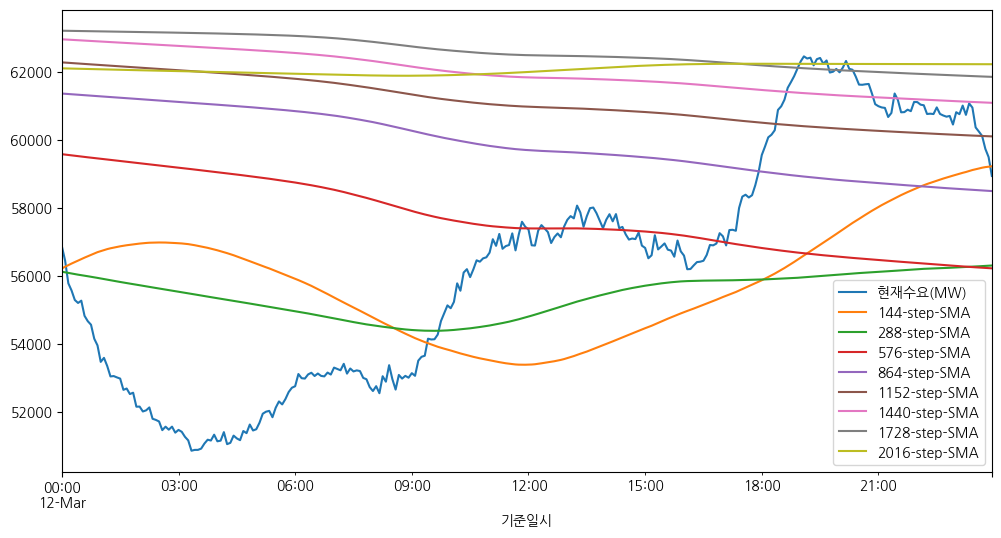

In [135]:
sma_train.iloc[-day:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### hour

In [209]:
sma_train = y_train.copy()

In [210]:
for i in target_time_h:
    sma_train[f'{i}-step-SMA_h'] = sma_train["현재수요(MW)"].rolling(window=i).mean()

In [35]:
sma_train.tail()

현재수요(MW)  12-step-SMA_h  24-step-SMA_h  36-step-SMA_h  \
기준일시                                                                         
2023-03-12 23:35:00  60235.18   60699.590000   60796.920833   60900.196111   
2023-03-12 23:40:00  60106.61   60649.477500   60767.716250   60857.995000   
2023-03-12 23:45:00  59725.49   60570.483333   60719.642917   60804.950278   
2023-03-12 23:50:00  59485.58   60469.706667   60663.400417   60753.043889   
2023-03-12 23:55:00  58929.88   60343.635000   60572.734167   60694.411944   

                     48-step-SMA_h  60-step-SMA_h  72-step-SMA_h  \
기준일시                                                               
2023-03-12 23:35:00   61174.795208   61371.052333   61103.740417   
2023-03-12 23:40:00   61128.559792   61347.483667   61128.864444   
2023-03-12 23:45:00   61081.780417   61314.758833   61147.762083   
2023-03-12 23:50:00   61029.498750   61275.066333   61159.238194   
2023-03-12 23:55:00   60963.925833   61222.465333   61157.760417   

                     84-step-SMA_h  96-step-SMA_h  108-step-SMA_h  ...  \
기준일시                                                               ...   
2023-03-12 23:35:00   60573.815119   60066.350833    59714.250093  ...   
2023-03-12 23:40:00   60611.978333   60101.449479    59742.167963  ...   
2023-03-12 23:45:00   60645.729881   60134.455208    59766.714907  ...   
2023-03-12 23:50:00   60675.990595   60160.010521    59787.244630  ...   
2023-03-12 23:55:00   60696.005714   60183.084271    59806.198241  ...   

                     180-step-SMA_h  192-step-SMA_h  204-step-SMA_h  \
기준일시                                                                  
2023-03-12 23:35:00    58364.370389    58022.180885    57738.047059   
2023-03-12 23:40:00    58403.404611    58058.178698    57772.624755   
2023-03-12 23:45:00    58440.913611    58093.239115    57805.403824   
2023-03-12 23:50:00    58476.646944    58127.255156    57836.458971   
2023-03-12 23:55:00    58509.591167    58159.576979    57865.075196   

                     216-step-SMA_h  228-step-SMA_h  240-step-SMA_h  \
기준일시                                                                  
2023-03-12 23:35:00    57466.032593    57166.325395    56867.194042   
2023-03-12 23:40:00    57502.570509    57204.369123    56904.870542   
2023-03-12 23:45:00    57536.612500    57241.018421    56940.491500   
2023-03-12 23:50:00    57568.589213    57275.503333    56975.210833   
2023-03-12 23:55:00    57597.407639    57308.317719    57006.899958   

                     252-step-SMA_h  264-step-SMA_h  276-step-SMA_h  \
기준일시                                                                  
2023-03-12 23:35:00    56598.889683    56393.456629    56269.159094   
2023-03-12 23:40:00    56632.805040    56421.580644    56288.888986   
2023-03-12 23:45:00    56665.556706    56448.876515    56307.614928   
2023-03-12 23:50:00    56697.001825    56475.116061    56326.960942   
2023-03-12 23:55:00    56726.944683    56500.806553    56345.005906   

                     288-step-SMA_h  
기준일시                                 
2023-03-12 23:35:00    56275.077465  
2023-03-12 23:40:00    56281.257257  
2023-03-12 23:45:00    56287.115035  
2023-03-12 23:50:00    56292.880312  
2023-03-12 23:55:00    56297.736111  

[5 rows x 25 columns]

In [36]:
sma_train.isna().sum()

현재수요(MW)            0
12-step-SMA_h      11
24-step-SMA_h      23
36-step-SMA_h      35
48-step-SMA_h      47
60-step-SMA_h      59
72-step-SMA_h      71
84-step-SMA_h      83
96-step-SMA_h      95
108-step-SMA_h    107
120-step-SMA_h    119
132-step-SMA_h    131
144-step-SMA_h    143
156-step-SMA_h    155
168-step-SMA_h    167
180-step-SMA_h    179
192-step-SMA_h    191
204-step-SMA_h    203
216-step-SMA_h    215
228-step-SMA_h    227
240-step-SMA_h    239
252-step-SMA_h    251
264-step-SMA_h    263
276-step-SMA_h    275
288-step-SMA_h    287
dtype: int64

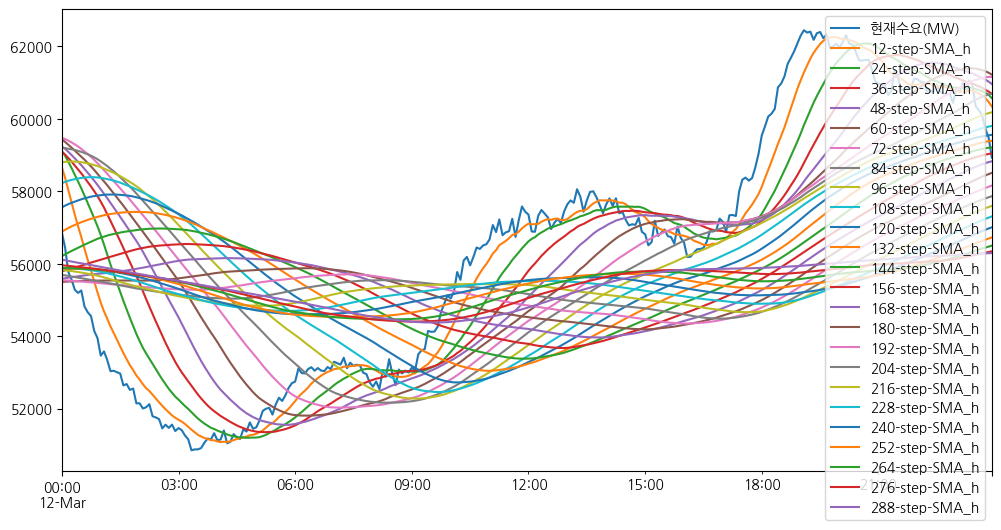

In [211]:
sma_train.iloc[-hour*24:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

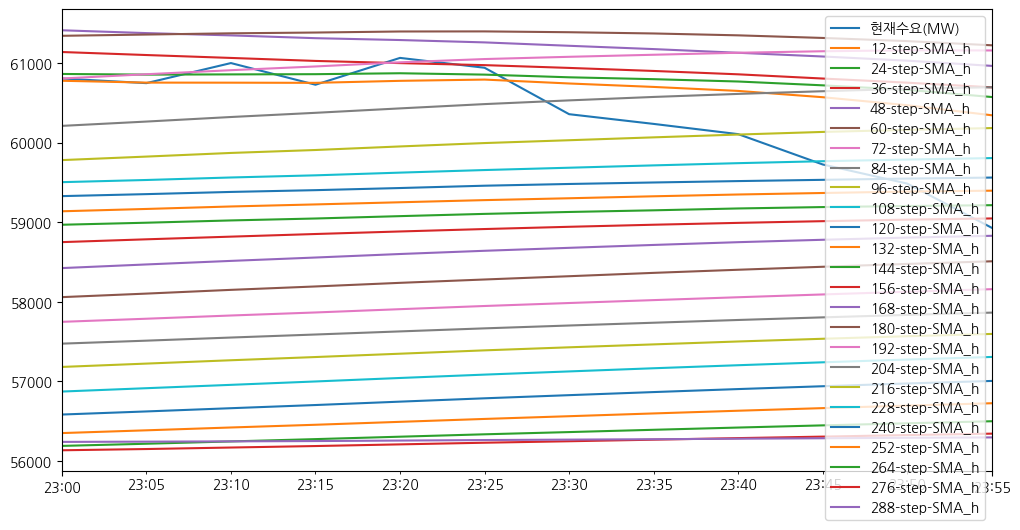

In [212]:
sma_train.iloc[-hour:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

## SES
Simple Exponential Smoothing

### day

In [174]:
ses_train = y_train.copy()
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [389]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
models = {}

for i in target_time:
    model = SimpleExpSmoothing(ses_train['현재수요(MW)']).fit(smoothing_level=2/(i+1),optimized=False)
    ses_train[f'SES{i}'] = model.fittedvalues.shift(-1)
    models[f'SES{i}'] = model

# 각 모델을 파일로 저장
for name, model in models.items():
    with open(f'meteorological/model/{name}_model.pkl', 'wb') as pkl:
        pickle.dump(model, pkl)
ses_train

현재수요(MW)        SES144        SES288        SES576  \
기준일시                                                                      
2022-04-01 00:00:00  62453.29  62453.290000  62453.290000  62453.290000   
2022-04-01 00:05:00  62329.25  62451.579103  62452.431592  62452.860052   
2022-04-01 00:10:00  61830.96  62443.018840  62448.130750  62450.704419   
2022-04-01 00:15:00  61648.72  62432.062994  62442.598496  62447.924577   
2022-04-01 00:20:00  61382.62  62417.587918  62435.263005  62444.232014   
...                       ...           ...           ...           ...   
2023-03-12 23:35:00  60235.18  59271.772503  57967.495504  57948.483166   
2023-03-12 23:40:00  60106.61  59283.287503  57982.299065  57955.963675   
2023-03-12 23:45:00  59725.49  59289.386848  57994.362670  57962.097215   
2023-03-12 23:50:00  59485.58  59292.092960  58004.682513  57967.377918   
2023-03-12 23:55:00  58929.88           NaN           NaN           NaN   

                           SES864       SES1152       SES1440       SES1728  \
기준일시                                                                          
2022-04-01 00:00:00  62453.290000  62453.290000  62453.290000  62453.290000   
2022-04-01 00:05:00  62453.003202  62453.074840  62453.117842  62453.146518   
2022-04-01 00:10:00  62451.564952  62451.995716  62452.254333  62452.426811   
2022-04-01 00:15:00  62449.708663  62450.602349  62451.139088  62451.497133   
2022-04-01 00:20:00  62447.241406  62448.749822  62449.656063  62450.260722   
...                           ...           ...           ...           ...   
2023-03-12 23:35:00  58682.796766  59372.790066  59935.724083  60396.876133   
2023-03-12 23:40:00  58686.088820  59374.062954  59935.961260  60396.540371   
2023-03-12 23:45:00  58688.492060  59374.672541  59935.669141  60395.764142   
2023-03-12 23:50:00  58690.335037  59374.864922  59935.044451  60394.711297   
2023-03-12 23:55:00           NaN           NaN           NaN           NaN   

                          SES2016  
기준일시                               
2022-04-01 00:00:00  62453.290000  
2022-04-01 00:05:00  62453.167005  
2022-04-01 00:10:00  62452.550043  
2022-04-01 00:15:00  62451.752988  
2022-04-01 00:20:00  62450.692866  
...                           ...  
2023-03-12 23:35:00  60786.246378  
2023-03-12 23:40:00  60785.572470  
2023-03-12 23:45:00  60784.521322  
2023-03-12 23:50:00  60783.233329  
2023-03-12 23:55:00           NaN  

[99648 rows x 9 columns]

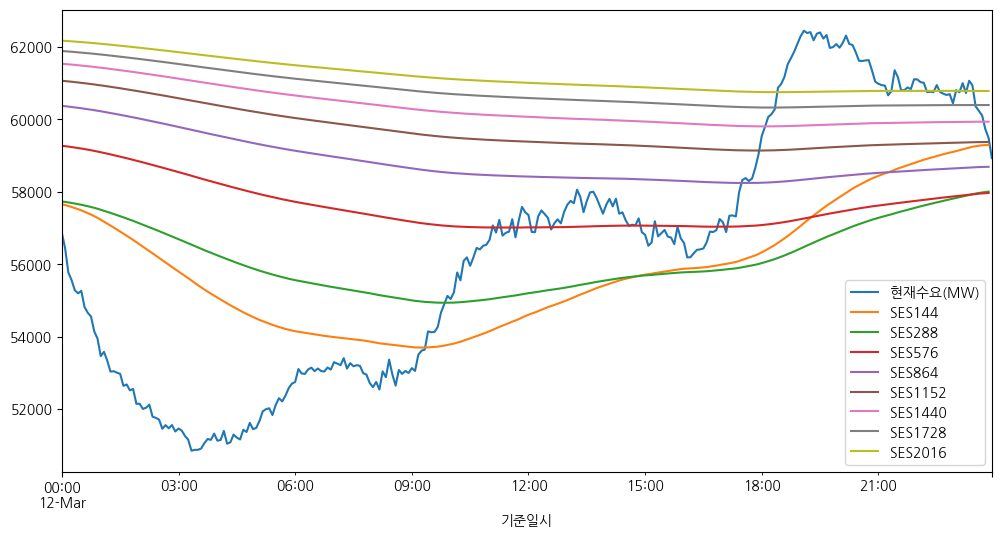

In [134]:
ses_train.iloc[-day:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### hour

In [40]:
ses_train = y_train.copy()

In [41]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
models = {}

for i in target_time_h:
    model = SimpleExpSmoothing(ses_train['현재수요(MW)']).fit(smoothing_level=2/(i+1),optimized=False)
    ses_train[f'SES{i}_h'] = model.fittedvalues.shift(-1)
    models[f'SES{i}_h'] = model

# 각 모델을 파일로 저장
for name, model in models.items():
    with open(f'meteorological/model/{name}_model.pkl', 'wb') as pkl:
        pickle.dump(model, pkl)
ses_train.tail()

현재수요(MW)       SES12_h       SES24_h       SES36_h  \
기준일시                                                                      
2023-03-12 23:35:00  60235.18  60690.301644  60807.711234  60845.103384   
2023-03-12 23:40:00  60106.61  60600.502930  60751.623135  60805.184822   
2023-03-12 23:45:00  59725.49  60465.885556  60669.532484  60746.822940   
2023-03-12 23:50:00  59485.58  60315.069317  60574.816286  60678.647646   
2023-03-12 23:55:00  58929.88           NaN           NaN           NaN   

                          SES48_h       SES60_h       SES72_h       SES84_h  \
기준일시                                                                          
2023-03-12 23:35:00  60780.599741  60644.268968  60465.832206  60265.740210   
2023-03-12 23:40:00  60753.089956  60626.640805  60455.990501  60261.995970   
2023-03-12 23:45:00  60711.147100  60597.094877  60435.976789  60249.372300   
2023-03-12 23:50:00  60661.123953  60560.651767  60409.938521  60231.400716   
2023-03-12 23:55:00           NaN           NaN           NaN           NaN   

                          SES96_h      SES108_h  ...      SES180_h  \
기준일시                                             ...                 
2023-03-12 23:35:00  60057.380165  59849.377534  ...  58797.603987   
2023-03-12 23:40:00  60058.395213  59854.097395  ...  58812.068142   
2023-03-12 23:45:00  60051.531188  59851.737627  ...  58822.161201   
2023-03-12 23:50:00  60039.862091  59845.019138  ...  58829.491796   
2023-03-12 23:55:00           NaN           NaN  ...           NaN   

                         SES192_h      SES204_h      SES216_h      SES228_h  \
기준일시                                                                          
2023-03-12 23:35:00  58663.835908  58541.695493  58430.697206  58330.302470   
2023-03-12 23:40:00  58678.786935  58556.962951  58446.143407  58345.816073   
2023-03-12 23:45:00  58689.633599  58568.363215  58457.934620  58357.865627   
2023-03-12 23:50:00  58697.881748  58577.311672  58467.406006  58367.714661   
2023-03-12 23:55:00           NaN           NaN           NaN           NaN   

                         SES240_h      SES252_h      SES264_h      SES276_h  \
기준일시                                                                          
2023-03-12 23:35:00  58239.945725  58159.052198  58087.050098  58023.378994   
2023-03-12 23:40:00  58255.436715  58174.447912  58102.292060  58038.420373   
2023-03-12 23:45:00  58267.636327  58186.709114  58114.542610  58050.601381   
2023-03-12 23:50:00  58277.743744  58196.976868  58124.890062  58060.962238   
2023-03-12 23:55:00           NaN           NaN           NaN           NaN   

                         SES288_h  
기준일시                               
2023-03-12 23:35:00  57967.495504  
2023-03-12 23:40:00  57982.299065  
2023-03-12 23:45:00  57994.362670  
2023-03-12 23:50:00  58004.682513  
2023-03-12 23:55:00           NaN  

[5 rows x 25 columns]

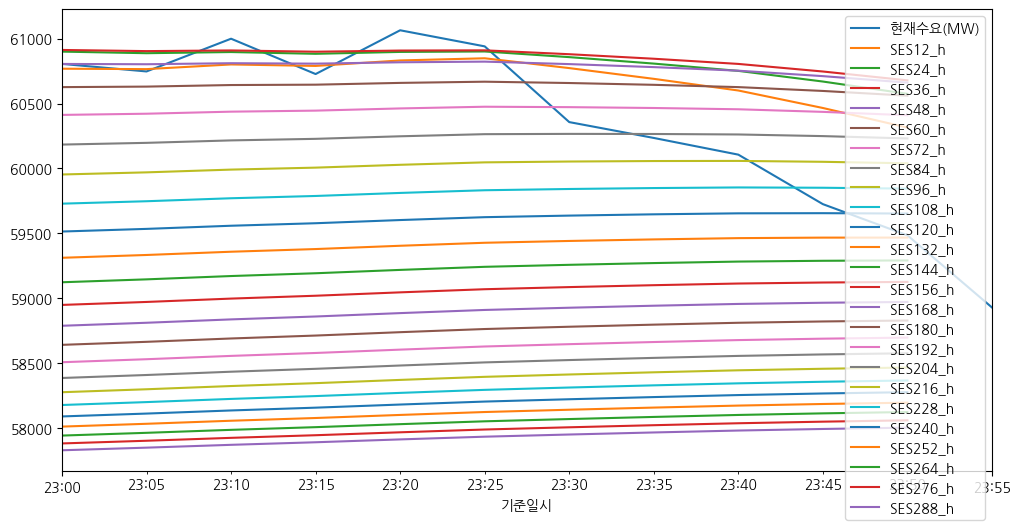

In [43]:
ses_train.iloc[-hour:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### Grid Search

In [175]:
model = SimpleExpSmoothing(ses_train['현재수요(MW)']).fit(optimized=True, use_brute=True)
ses_train['SESgrid'] = model.fittedvalues.shift(-1)

print(ses_train)

                     현재수요(MW)       SESgrid
2022-04-01 00:00:00  62453.29  62453.290000
2022-04-01 00:05:00  62329.25  62329.870200
2022-04-01 00:10:00  61830.96  61833.454551
2022-04-01 00:15:00  61648.72  61649.643673
2022-04-01 00:20:00  61382.62  61383.955118
...                       ...           ...
2023-03-12 23:35:00  60235.18  60235.804943
2023-03-12 23:40:00  60106.61  60107.255975
2023-03-12 23:45:00  59725.49  59727.398830
2023-03-12 23:50:00  59485.58  59486.789094
2023-03-12 23:55:00  58929.88           NaN

[99648 rows x 2 columns]


In [176]:
model = SimpleExpSmoothing(ses_train['현재수요(MW)']).fit(optimized=True, use_brute=False)
ses_train['SESgrid_2'] = model.fittedvalues.shift(-1)

print(ses_train)

                     현재수요(MW)       SESgrid     SESgrid_2
2022-04-01 00:00:00  62453.29  62453.290000  62453.290000
2022-04-01 00:05:00  62329.25  62329.870200  62391.270000
2022-04-01 00:10:00  61830.96  61833.454551  62111.115000
2022-04-01 00:15:00  61648.72  61649.643673  61879.917500
2022-04-01 00:20:00  61382.62  61383.955118  61631.268750
...                       ...           ...           ...
2023-03-12 23:35:00  60235.18  60235.804943  60440.528788
2023-03-12 23:40:00  60106.61  60107.255975  60273.569394
2023-03-12 23:45:00  59725.49  59727.398830  59999.529697
2023-03-12 23:50:00  59485.58  59486.789094  59742.554848
2023-03-12 23:55:00  58929.88           NaN           NaN

[99648 rows x 3 columns]


<AxesSubplot:>

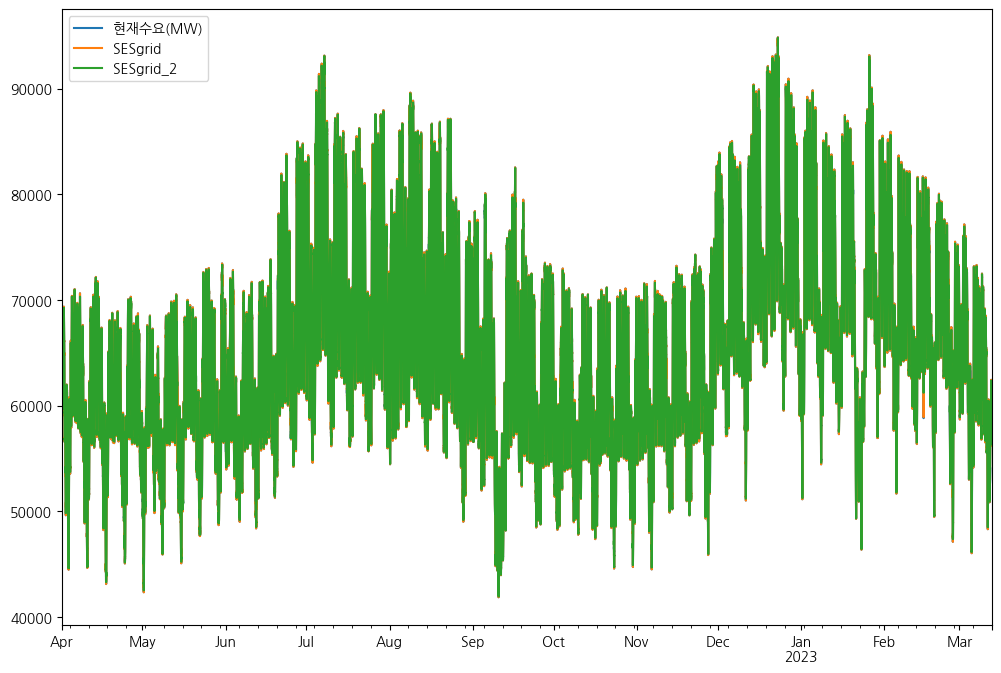

In [178]:
ses_train.plot(figsize= (12,8))

In [179]:
model.params

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 62453.29,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## DES(additive/multiplicative)
Double Exponential Smoothing

- Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

- We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

- As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

### day

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
des_train = y_train.copy()

In [415]:
# plot을 보면 구간의 추세가 직선 경사인지, 지수 경사인지 분포를 알기 어렵다. 따라서 additive, multiplicative 모델 둘다 적용
from statsmodels.tsa.holtwinters import ExponentialSmoothing

models = {}

for i in target_time:
    model_add = ExponentialSmoothing(des_train['현재수요(MW)'], trend='add').fit(smoothing_level=2/(i+1))
    des_train[f'DESadd{i}'] = model_add.fittedvalues.shift(-1)
    models[f'DESadd{i}'] = model_add

    model_mul = ExponentialSmoothing(des_train['현재수요(MW)'], trend='mul').fit(smoothing_level=2/(i+1))
    des_train[f'DESmul{i}'] = model_mul.fittedvalues.shift(-1)
    models[f'DESmul{i}'] = model_mul

# 각 모델을 파일로 저장
for name, model in models.items():
    with open(f'meteorological/model/{name}_model.pkl', 'wb') as pkl:
        pickle.dump(model, pkl)
des_train.tail()

C:\Users\ppjjh\anaconda3\envs\park\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ppjjh\anaconda3\envs\park\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ppjjh\anaconda3\envs\park\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1388: RuntimeWarning: overflow encountered in multiply
  alphac * trended(lvls[i - 1], dampen(b[i - 1], phi))
C:\Users\ppjjh\anaconda3\envs\park\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1391: RuntimeWarning: invalid value encountered in true_divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + (
C:\Users\ppjjh\anaconda3\envs\park\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1400: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\Users\ppjjh\anaconda3\envs\park\lib\site-packages\statsmodels\tsa\holtwint

현재수요(MW)     DESadd144     DESadd288     DESadd576  \
기준일시                                                                      
2023-03-12 23:35:00  60235.18  59669.792304  56421.236572  53961.402834   
2023-03-12 23:40:00  60106.61  59693.710069  56445.133518  53973.505444   
2023-03-12 23:45:00  59725.49  59712.043298  56466.293125  53984.314171   
2023-03-12 23:50:00  59485.58  59726.798934  56485.706349  53994.319951   
2023-03-12 23:55:00  58929.88           NaN           NaN           NaN   

                        DESadd864    DESadd1152    DESadd1440    DESadd1728  \
기준일시                                                                          
2023-03-12 23:35:00  56228.100376  57966.563566  58874.167207  59355.810124   
2023-03-12 23:40:00  56227.376320  57964.067312  58871.629274  59353.542131   
2023-03-12 23:45:00  56225.791436  57960.919595  58868.567541  59350.836404   
2023-03-12 23:50:00  56223.672938  57957.365776  58865.178269  59347.856474   
2023-03-12 23:55:00           NaN           NaN           NaN           NaN   

                       DESadd2016     DESmul144     DESmul288     DESmul576  \
기준일시                                                                          
2023-03-12 23:35:00  59563.585503  59714.227271  56740.462218  54320.590009   
2023-03-12 23:40:00  59561.566720  59738.355402  56760.117452  54332.727733   
2023-03-12 23:45:00  59559.172191  59756.898826  56777.037495  54343.565580   
2023-03-12 23:50:00  59556.542077  59771.863352  56792.215213  54353.594633   
2023-03-12 23:55:00           NaN           NaN           NaN           NaN   

                        DESmul864    DESmul1152    DESmul1440    DESmul2016  \
기준일시                                                                          
2023-03-12 23:35:00  57387.509323  58268.832580  58912.927540  59599.918961   
2023-03-12 23:40:00  57388.478235  58267.383337  58910.488877  59597.928657   
2023-03-12 23:45:00  57388.570909  58265.279091  58907.526409  59595.562643   
2023-03-12 23:50:00  57388.115179  58262.765400  58904.236417  59592.961088   
2023-03-12 23:55:00           NaN           NaN           NaN           NaN   

                     DESmul1728  
기준일시                             
2023-03-12 23:35:00         NaN  
2023-03-12 23:40:00         NaN  
2023-03-12 23:45:00         NaN  
2023-03-12 23:50:00         NaN  
2023-03-12 23:55:00         NaN

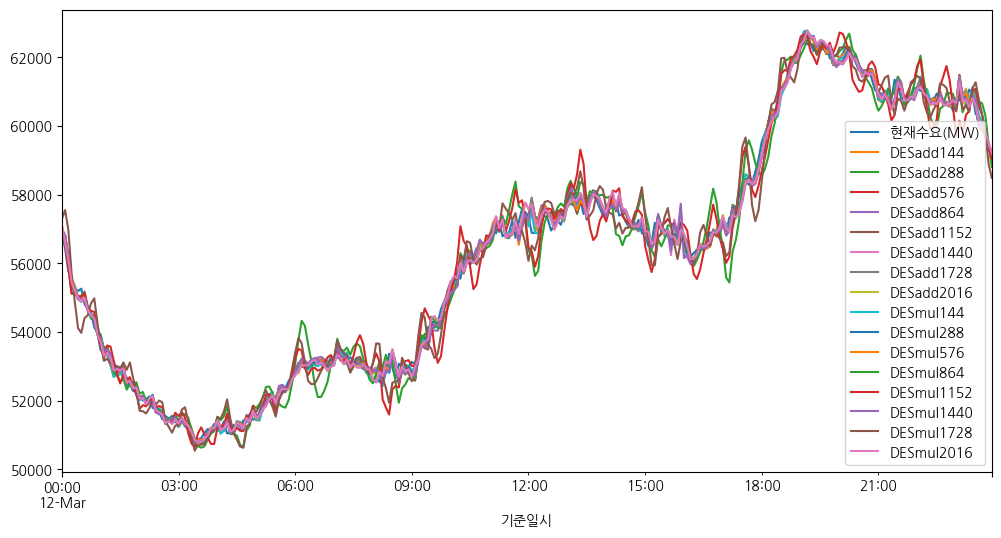

In [115]:
des_train.isna().sum()

In [416]:
des_train['DESmul1728'].isna().sum()

99583

In [417]:
des_train = des_train.drop('DESmul1728', axis=1)

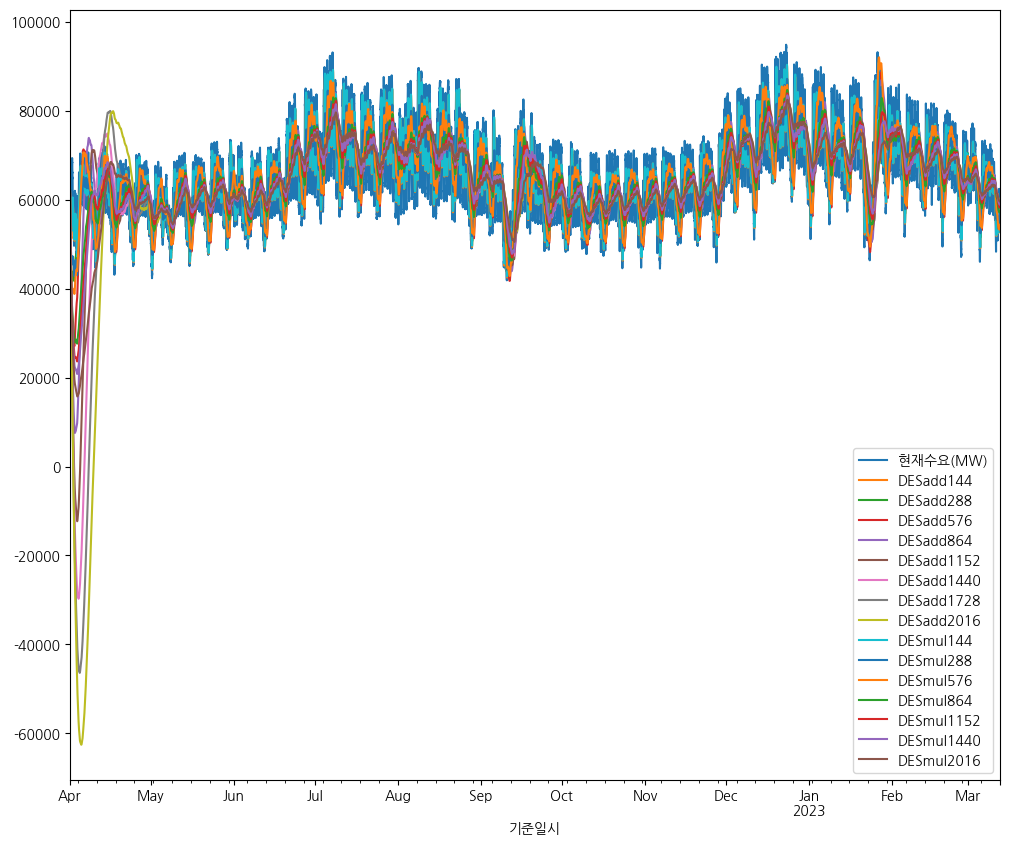

In [418]:
des_train.plot(figsize = (12,10));

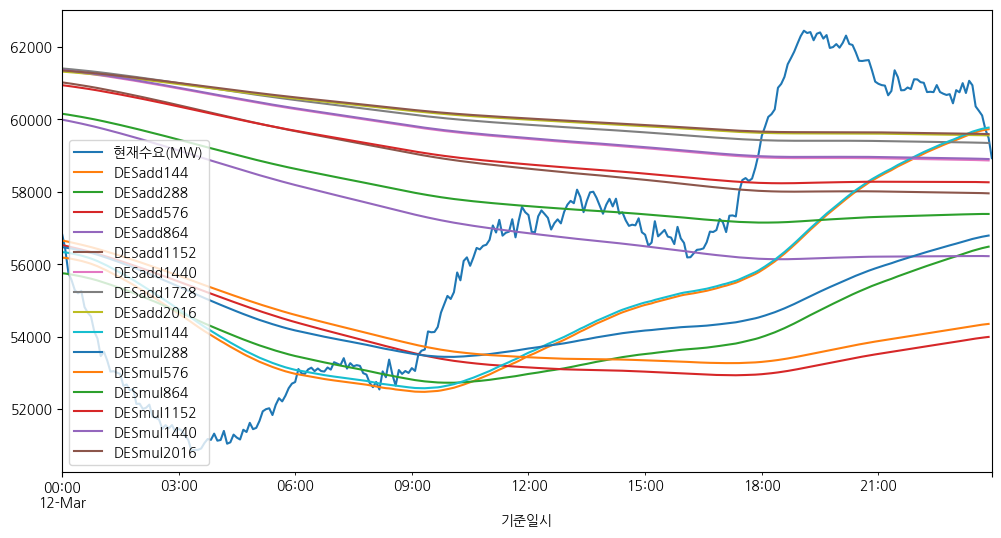

In [419]:
des_train.iloc[-day:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### hour

In [219]:
des_train = y_train.copy()

In [220]:
# plot을 보면 구간의 추세가 직선 경사인지, 지수 경사인지 분포를 알기 어렵다. 따라서 additive, multiplicative 모델 둘다 적용
from statsmodels.tsa.holtwinters import ExponentialSmoothing

models = {}

for i in target_time_h:
    model_add = ExponentialSmoothing(des_train['현재수요(MW)'], trend='add').fit(smoothing_level=2/(i+1))
    des_train[f'DESadd{i}_h'] = model_add.fittedvalues.shift(-1)
    models[f'DESadd{i}_h'] = model_add

    model_mul = ExponentialSmoothing(des_train['현재수요(MW)'], trend='mul').fit(smoothing_level=2/(i+1))
    des_train[f'DESmul{i}_h'] = model_mul.fittedvalues.shift(-1)
    models[f'DESmul{i}_h'] = model_mul

# 각 모델을 파일로 저장
for name, model in models.items():
    with open(f'meteorological/model/{name}_model.pkl', 'wb') as pkl:
        pickle.dump(model, pkl)
des_train.tail()

현재수요(MW)    DESadd12_h    DESmul12_h    DESadd24_h  \
2023-03-12 23:35:00  60235.18  60671.793344  60671.368099  60263.843655   
2023-03-12 23:40:00  60106.61  60564.780098  60564.322290  60193.088324   
2023-03-12 23:45:00  59725.49  60396.377335  60395.999418  60094.698229   
2023-03-12 23:50:00  59485.58  60196.116738  60195.993476  59981.331833   
2023-03-12 23:55:00  58929.88           NaN           NaN           NaN   

                       DESmul24_h    DESadd36_h    DESmul36_h    DESadd48_h  \
2023-03-12 23:35:00  60261.544222  61388.370131  61425.158843  61893.425292   
2023-03-12 23:40:00  60190.282542  61295.737307  61330.392847  61834.064493   
2023-03-12 23:45:00  60091.541735  61183.346959  61215.942603  61758.488160   
2023-03-12 23:50:00  59977.990875  61059.561909  61090.186484  61672.881586   
2023-03-12 23:55:00           NaN           NaN           NaN           NaN   

                       DESmul48_h    DESadd60_h  ...   DESadd240_h  \
2023-03-12 23:35:00  61303.581505  61209.282750  ...  57205.337671   
2023-03-12 23:40:00  61275.992446  61193.556518  ...  57231.866314   
2023-03-12 23:45:00  61233.642752  61165.609496  ...  57255.080246   
2023-03-12 23:50:00  61182.855676  61130.437454  ...  57276.171637   
2023-03-12 23:55:00           NaN           NaN  ...           NaN   

                      DESmul240_h   DESadd252_h   DESmul252_h   DESadd264_h  \
2023-03-12 23:35:00  57319.950338  56960.369489  57083.475518  56780.624479   
2023-03-12 23:40:00  57345.973176  56985.258362  57107.864914  56803.840929   
2023-03-12 23:45:00  57368.683546  57007.000610  57129.109023  56824.061949   
2023-03-12 23:50:00  57389.273526  57026.731383  57148.342993  56842.370881   
2023-03-12 23:55:00           NaN           NaN           NaN           NaN   

                      DESmul264_h   DESadd276_h   DESmul276_h   DESadd288_h  \
2023-03-12 23:35:00  56907.758077  56602.752042  56794.131965  56421.236572   
2023-03-12 23:40:00  56930.512597  56626.021266  56815.294866  56445.133518   
2023-03-12 23:45:00  56950.272275  56646.429802  56833.598979  56466.293125   
2023-03-12 23:50:00  56968.120519  56665.012907  56850.080472  56485.706349   
2023-03-12 23:55:00           NaN           NaN           NaN           NaN   

                      DESmul288_h  
2023-03-12 23:35:00  56740.462218  
2023-03-12 23:40:00  56760.117452  
2023-03-12 23:45:00  56777.037495  
2023-03-12 23:50:00  56792.215213  
2023-03-12 23:55:00           NaN  

[5 rows x 49 columns]

In [221]:
des_train.isna().sum()

현재수요(MW)       0
DESadd12_h     1
DESmul12_h     1
DESadd24_h     1
DESmul24_h     1
DESadd36_h     1
DESmul36_h     1
DESadd48_h     1
DESmul48_h     1
DESadd60_h     1
DESmul60_h     1
DESadd72_h     1
DESmul72_h     1
DESadd84_h     1
DESmul84_h     1
DESadd96_h     1
DESmul96_h     1
DESadd108_h    1
DESmul108_h    1
DESadd120_h    1
DESmul120_h    1
DESadd132_h    1
DESmul132_h    1
DESadd144_h    1
DESmul144_h    1
DESadd156_h    1
DESmul156_h    1
DESadd168_h    1
DESmul168_h    1
DESadd180_h    1
DESmul180_h    1
DESadd192_h    1
DESmul192_h    1
DESadd204_h    1
DESmul204_h    1
DESadd216_h    1
DESmul216_h    1
DESadd228_h    1
DESmul228_h    1
DESadd240_h    1
DESmul240_h    1
DESadd252_h    1
DESmul252_h    1
DESadd264_h    1
DESmul264_h    1
DESadd276_h    1
DESmul276_h    1
DESadd288_h    1
DESmul288_h    1
dtype: int64

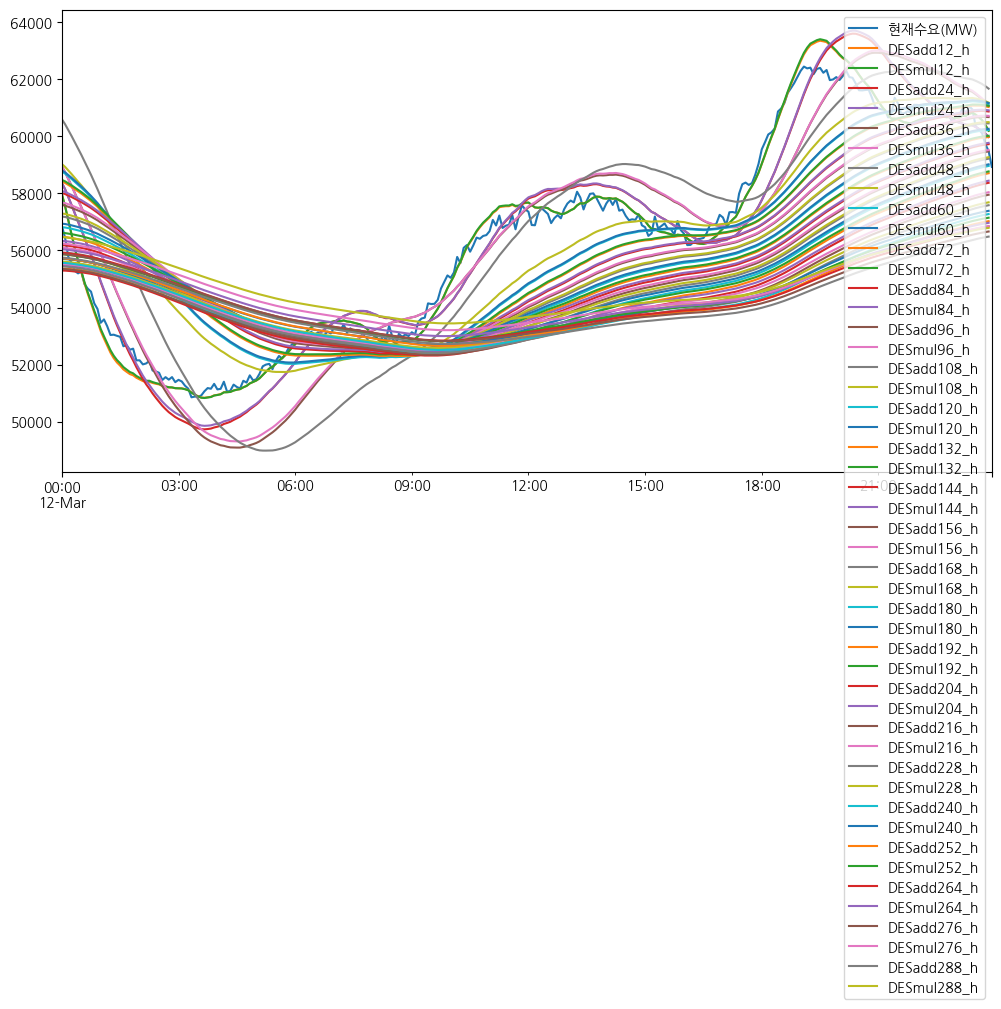

In [222]:
des_train.iloc[-day:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### Grid Search

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_add = ExponentialSmoothing(des_train['현재수요(MW)'], trend='add').fit(optimized=True)
des_train['DESgrid'] = model_add.fittedvalues.shift(-1)
print(model_add.params)

C:\Users\ppjjh\anaconda3\envs\torch2\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{'smoothing_level': 0.995, 'smoothing_trend': 0.1895238095238095, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 62609.41999999997, 'initial_trend': -220.00927272726767, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [27]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_add = ExponentialSmoothing(des_train['현재수요(MW)'], trend='mul').fit(optimized=True)
des_train['DESgrid_2'] = model_add.fittedvalues.shift(-1)
print(model_add.params)

C:\Users\ppjjh\anaconda3\envs\torch2\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{'smoothing_level': 0.995, 'smoothing_trend': 0.1895238095238095, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 62609.41999999997, 'initial_trend': 0.996486003660036, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


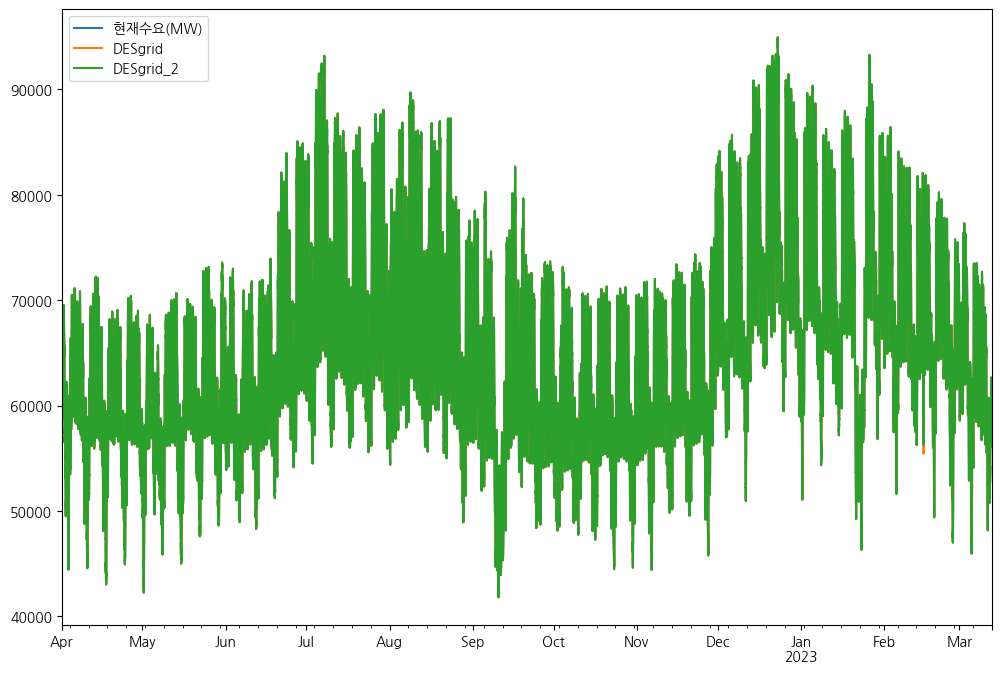

In [184]:
des_train.plot(figsize = (12,8));

## TES(additive/multiplicative)
Triple Exponential Smoothing

### day

In [223]:
tes_tr_add = y_train.copy()

In [224]:

from tqdm import tqdm


models = {}

for i in tqdm(target_time):
    model_add = ExponentialSmoothing(tes_tr_add['현재수요(MW)'], trend='add', seasonal='add', seasonal_periods=i).fit()
    tes_tr_add[f'TESadd_add{i}'] = model_add.fittedvalues
    models[f'TESadd_add{i}'] = model_add

for i in tqdm(target_time):
    model_mul = ExponentialSmoothing(tes_tr_add['현재수요(MW)'], trend='add', seasonal='mul', seasonal_periods=i).fit()
    tes_tr_add[f'TESadd_mul{i}'] = model_mul.fittedvalues
    models[f'TESadd_mul{i}'] = model_mul

# 각 모델을 파일로 저장
for name, model in models.items():
    with open(f'meteorological/model/{name}_model.pkl', 'wb') as pkl:
        pickle.dump(model, pkl)
tes_tr_add.tail()

100%|██████████| 8/8 [03:27<00:00, 25.95s/it]


현재수요(MW)  TESadd_add144  TESadd_add288  TESadd_add576  \
2023-03-12 23:35:00  60235.18   60158.011709   59982.698785   60005.797340   
2023-03-12 23:40:00  60106.61   59966.277155   59892.774057   59877.647172   
2023-03-12 23:45:00  59725.49   59805.396788   59755.032509   59722.194792   
2023-03-12 23:50:00  59485.58   59348.997755   59419.897408   59407.594372   
2023-03-12 23:55:00  58929.88   59026.968256   59166.557233   59152.691622   

                     TESadd_add864  TESadd_add1152  TESadd_add1440  \
2023-03-12 23:35:00   59995.614902    60062.574849    60033.341526   
2023-03-12 23:40:00   59883.276613    59967.468443    59986.608128   
2023-03-12 23:45:00   59792.086141    59799.005575    59803.531401   
2023-03-12 23:50:00   59394.822919    59453.603367    59429.921391   
2023-03-12 23:55:00   59144.619818    59204.276816    59279.477517   

                     TESadd_add1728  TESadd_add2016  TESadd_mul144  \
2023-03-12 23:35:00    60026.956526    60149.436537   60318.039430   
2023-03-12 23:40:00    59874.495587    60093.946831   60101.143996   
2023-03-12 23:45:00    59843.602221    59867.660936   59915.469128   
2023-03-12 23:50:00    59444.096094    59535.186933   59417.684863   
2023-03-12 23:55:00    59231.020419    59200.568056   59045.039716   

                     TESadd_mul288  TESadd_mul576  TESadd_mul864  \
2023-03-12 23:35:00   61980.429092   60023.869472   60020.479716   
2023-03-12 23:40:00   62199.514584   59885.585919   59893.632379   
2023-03-12 23:45:00   61242.235589   59730.993463   59792.671422   
2023-03-12 23:50:00   59447.678247   59410.336519   59396.211684   
2023-03-12 23:55:00   57876.306195   59155.102647   59145.433330   

                     TESadd_mul1152  TESadd_mul1440  TESadd_mul1728  \
2023-03-12 23:35:00    60072.672141    60326.880922    60039.161885   
2023-03-12 23:40:00    59963.033853    60269.398897    59871.549052   
2023-03-12 23:45:00    59797.945899    59903.161765    59819.806397   
2023-03-12 23:50:00    59444.394923    59286.934095    59428.089378   
2023-03-12 23:55:00    59194.488126    59071.204187    59206.175210   

                     TESadd_mul2016  
2023-03-12 23:35:00    60120.988805  
2023-03-12 23:40:00    60056.641780  
2023-03-12 23:45:00    59835.477366  
2023-03-12 23:50:00    59518.584361  
2023-03-12 23:55:00    59187.097117

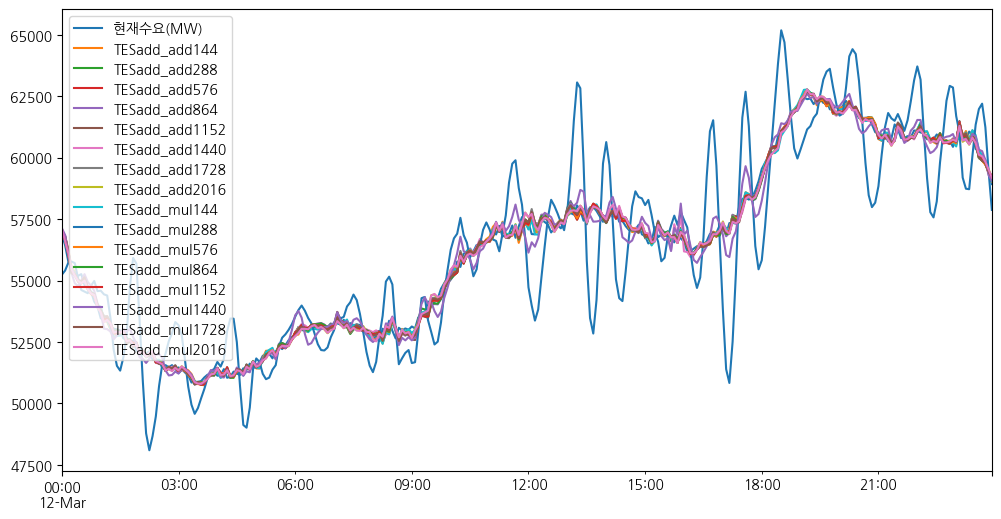

In [225]:
tes_tr_add.iloc[-day:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [226]:
tes_tr_mul = y_train.copy()

In [227]:

models = {}

for i in tqdm(target_time):
    model_mul_add = ExponentialSmoothing(tes_tr_mul['현재수요(MW)'], trend='mul', seasonal='add', seasonal_periods=i).fit()
    tes_tr_mul[f'TESmul_add{i}'] = model_mul_add.fittedvalues
    models[f'TESmul_add{i}'] = model_mul_add

for i in tqdm(target_time):
    model_mul_mul = ExponentialSmoothing(tes_tr_mul['현재수요(MW)'], trend='mul', seasonal='mul', seasonal_periods=i).fit()
    tes_tr_mul[f'TESmul_mul{i}'] = model_mul_mul.fittedvalues
    models[f'TESmul_mul{i}'] = model_mul_mul

# 각 모델을 파일로 저장
for name, model in models.items():
    with open(f'meteorological/model/{name}_model.pkl', 'wb') as pkl:
        pickle.dump(model, pkl)
tes_tr_mul.tail()

100%|██████████| 8/8 [04:20<00:00, 32.55s/it]


현재수요(MW)  TESmul_add144  TESmul_add288  TESmul_add576  \
2023-03-12 23:35:00  60235.18   60158.817880   59969.985601   60006.908822   
2023-03-12 23:40:00  60106.61   59967.157622   59886.054158   59878.973399   
2023-03-12 23:45:00  59725.49   59806.207955   59757.376324   59723.636529   
2023-03-12 23:50:00  59485.58   59349.785656   59425.762180   59408.895868   
2023-03-12 23:55:00  58929.88   59027.531233   59180.295650   59153.824513   

                     TESmul_add864  TESmul_add1152  TESmul_add1440  \
2023-03-12 23:35:00   59996.985394    60064.137160    60034.718526   
2023-03-12 23:40:00   59884.910289    59969.162026    59988.110298   
2023-03-12 23:45:00   59794.019887    59800.773027    59805.160217   
2023-03-12 23:50:00   59396.562596    59455.151464    59431.402831   
2023-03-12 23:55:00   59146.422671    59205.773787    59281.019929   

                     TESmul_add1728  TESmul_add2016  TESmul_mul144  \
2023-03-12 23:35:00    60028.159642    60150.845145   60318.557774   
2023-03-12 23:40:00    59875.769491    60095.456613   60101.552946   
2023-03-12 23:45:00    59845.108660    59869.128261   59915.797270   
2023-03-12 23:50:00    59445.390061    59536.480278   59418.300561   
2023-03-12 23:55:00    59232.336769    59201.707103   59045.724546   

                     TESmul_mul288  TESmul_mul576  TESmul_mul864  \
2023-03-12 23:35:00   62751.255134   60024.834257   60021.554754   
2023-03-12 23:40:00   63035.544705   59886.741748   59894.916624   
2023-03-12 23:45:00   61779.426145   59732.222139   59794.205623   
2023-03-12 23:50:00   59527.024351   59411.427681   59397.576127   
2023-03-12 23:55:00   57560.154322   59156.025273   59146.861732   

                     TESmul_mul1152  TESmul_mul1440  TESmul_mul1728  \
2023-03-12 23:35:00    60599.676254    60037.129759    60027.733295   
2023-03-12 23:40:00    60329.212496    59985.202734    59869.139395   
2023-03-12 23:45:00    59895.287673    59796.133472    59829.937585   
2023-03-12 23:50:00    59345.156639    59407.695037    59438.635650   
2023-03-12 23:55:00    59042.327923    59275.918828    59222.756686   

                     TESmul_mul2016  
2023-03-12 23:35:00    60122.479115  
2023-03-12 23:40:00    60058.305320  
2023-03-12 23:45:00    59837.177459  
2023-03-12 23:50:00    59520.152902  
2023-03-12 23:55:00    59188.531147

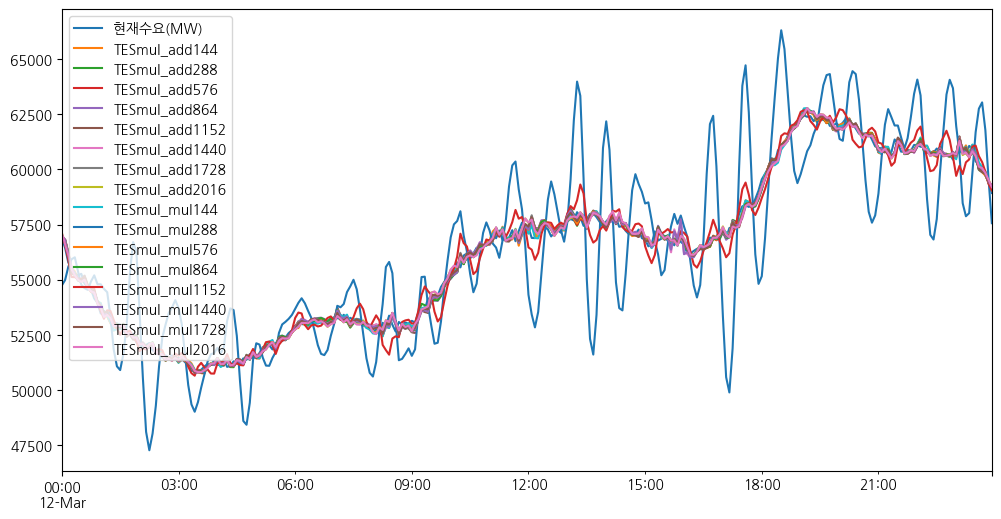

In [228]:
tes_tr_mul.iloc[-day:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### hour

In [229]:
tes_tr_add = y_train.copy()

In [230]:

from tqdm import tqdm


models = {}

for i in tqdm(target_time_h):
    model_add = ExponentialSmoothing(tes_tr_add['현재수요(MW)'], trend='add', seasonal='add', seasonal_periods=i).fit()
    tes_tr_add[f'TESadd_add{i}_h'] = model_add.fittedvalues
    models[f'TESadd_add{i}_h'] = model_add

for i in tqdm(target_time_h):
    model_mul = ExponentialSmoothing(tes_tr_add['현재수요(MW)'], trend='add', seasonal='mul', seasonal_periods=i).fit()
    tes_tr_add[f'TESadd_mul{i}_h'] = model_mul.fittedvalues
    models[f'TESadd_mul{i}_h'] = model_mul

# 각 모델을 파일로 저장
for name, model in models.items():
    with open(f'meteorological/model/{name}_model.pkl', 'wb') as pkl:
        pickle.dump(model, pkl)
tes_tr_add.tail()

100%|██████████| 24/24 [03:30<00:00,  8.78s/it]


현재수요(MW)  TESadd_add12_h  TESadd_add24_h  TESadd_add36_h  \
2023-03-12 23:35:00  60235.18    60309.181072    60158.077083    60459.729310   
2023-03-12 23:40:00  60106.61    60155.439798    59962.128177    60261.078555   
2023-03-12 23:45:00  59725.49    59991.864103    59878.825892    60065.031721   
2023-03-12 23:50:00  59485.58    59563.571376    59480.017707    59554.697234   
2023-03-12 23:55:00  58929.88    59298.975288    59260.880510    59218.020587   

                     TESadd_add48_h  TESadd_add60_h  TESadd_add72_h  \
2023-03-12 23:35:00    60285.050087    60372.621982    60444.094043   
2023-03-12 23:40:00    60134.323564    60182.815704    60209.312742   
2023-03-12 23:45:00    60061.178902    60041.528877    60037.924308   
2023-03-12 23:50:00    59679.121849    59561.183108    59514.819744   
2023-03-12 23:55:00    59415.971686    59229.984728    59176.598117   

                     TESadd_add84_h  TESadd_add96_h  TESadd_add108_h  ...  \
2023-03-12 23:35:00    60247.592176    60139.921615     60411.214314  ...   
2023-03-12 23:40:00    60038.026093    59941.708174     60207.803428  ...   
2023-03-12 23:45:00    59936.100363    59885.760477     60052.554408  ...   
2023-03-12 23:50:00    59516.740648    59497.786734     59535.076769  ...   
2023-03-12 23:55:00    59287.429061    59231.255503     59242.246829  ...   

                     TESadd_mul180_h  TESadd_mul192_h  TESadd_mul204_h  \
2023-03-12 23:35:00     60400.047916     61455.401664     60318.402664   
2023-03-12 23:40:00     60141.598410     61434.022206     60114.900400   
2023-03-12 23:45:00     59923.601775     61870.460080     60029.126954   
2023-03-12 23:50:00     59450.421112     61895.296826     59578.451710   
2023-03-12 23:55:00     59185.870556     61685.786011     59357.736216   

                     TESadd_mul216_h  TESadd_mul228_h  TESadd_mul240_h  \
2023-03-12 23:35:00     63100.445707     58767.431200     60262.511071   
2023-03-12 23:40:00     60867.643857     59860.467354     60054.198047   
2023-03-12 23:45:00     59384.974658     61100.761159     59904.396666   
2023-03-12 23:50:00     58614.653136     61606.534354     59473.455210   
2023-03-12 23:55:00     58545.113576     61936.636380     59175.558378   

                     TESadd_mul252_h  TESadd_mul264_h  TESadd_mul276_h  \
2023-03-12 23:35:00     60265.155524     62323.394958     60296.018068   
2023-03-12 23:40:00     60044.147548     62083.366473     60080.423484   
2023-03-12 23:45:00     59921.519474     61612.884341     59920.525201   
2023-03-12 23:50:00     59488.389190     60934.799910     59525.916499   
2023-03-12 23:55:00     59209.390194     60359.406732     59207.547962   

                     TESadd_mul288_h  
2023-03-12 23:35:00     61980.429092  
2023-03-12 23:40:00     62199.514584  
2023-03-12 23:45:00     61242.235589  
2023-03-12 23:50:00     59447.678247  
2023-03-12 23:55:00     57876.306195  

[5 rows x 49 columns]

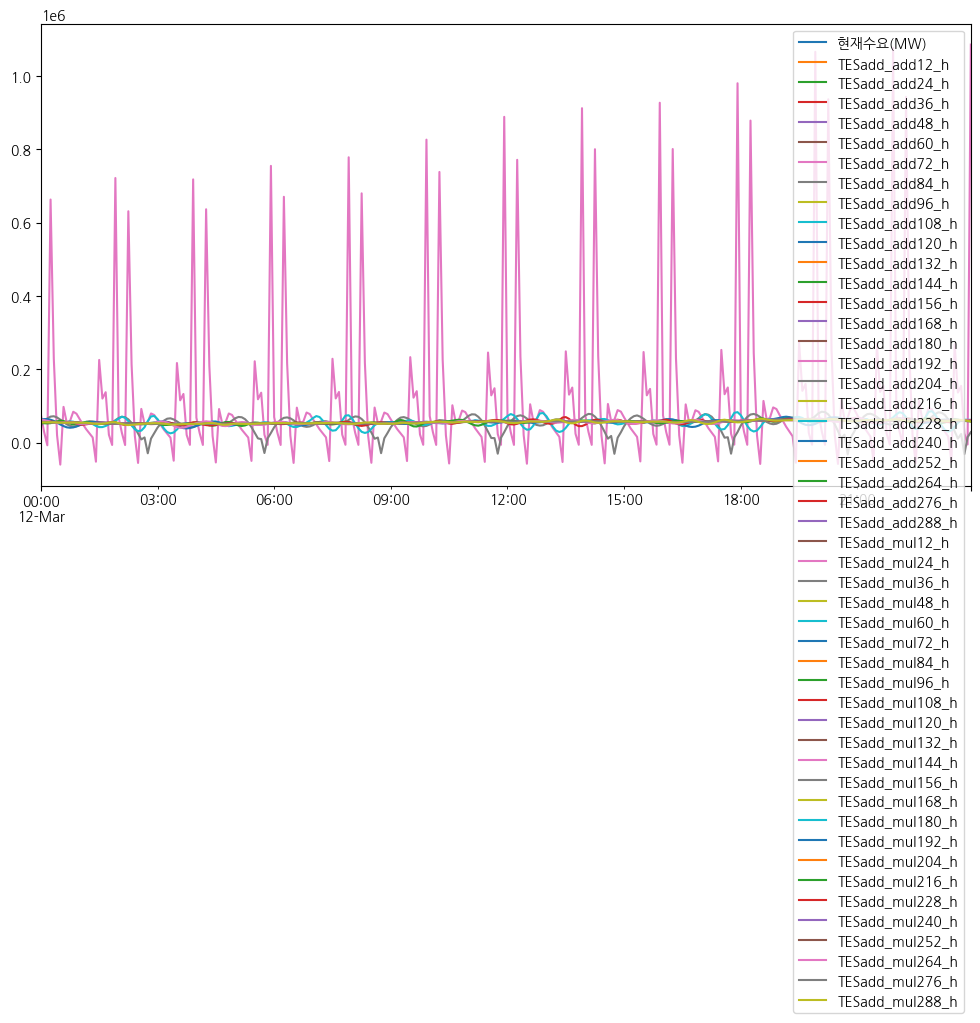

In [231]:
tes_tr_add.iloc[-day:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [232]:
tes_tr_mul = y_train.copy()

In [233]:

models = {}

for i in tqdm(target_time_h):
    model_mul_add = ExponentialSmoothing(tes_tr_mul['현재수요(MW)'], trend='mul', seasonal='add', seasonal_periods=i).fit()
    tes_tr_mul[f'TESmul_add{i}_h'] = model_mul_add.fittedvalues
    models[f'TESmul_add{i}_h'] = model_mul_add

for i in tqdm(target_time_h):
    model_mul_mul = ExponentialSmoothing(tes_tr_mul['현재수요(MW)'], trend='mul', seasonal='mul', seasonal_periods=i).fit()
    tes_tr_mul[f'TESmul_mul{i}_h'] = model_mul_mul.fittedvalues
    models[f'TESmul_mul{i}_h'] = model_mul_mul

# 각 모델을 파일로 저장
for name, model in models.items():
    with open(f'meteorological/model/{name}_model.pkl', 'wb') as pkl:
        pickle.dump(model, pkl)
tes_tr_mul.tail()

100%|██████████| 24/24 [06:04<00:00, 15.20s/it]


현재수요(MW)  TESmul_add12_h  TESmul_add24_h  TESmul_add36_h  \
2023-03-12 23:35:00  60235.18    60311.437979    60160.508560    60461.066556   
2023-03-12 23:40:00  60106.61    60157.800241    59963.838267    60262.521345   
2023-03-12 23:45:00  59725.49    59994.043892    59878.962455    60066.813873   
2023-03-12 23:50:00  59485.58    59565.741298    59480.183561    59557.941248   
2023-03-12 23:55:00  58929.88    59300.679881    59261.139348    59221.976094   

                     TESmul_add48_h  TESmul_add60_h  TESmul_add72_h  \
2023-03-12 23:35:00    60285.690631    60375.140512    60445.328217   
2023-03-12 23:40:00    60134.962136    60185.713297    60210.513129   
2023-03-12 23:45:00    60060.183109    60044.770925    60039.072980   
2023-03-12 23:50:00    59679.139337    59566.177460    59517.107944   
2023-03-12 23:55:00    59416.999732    59235.940163    59179.219132   

                     TESmul_add84_h  TESmul_add96_h  TESmul_add108_h  ...  \
2023-03-12 23:35:00    60250.399004    60141.496376     60412.678931  ...   
2023-03-12 23:40:00    60041.061945    59942.437874     60209.216044  ...   
2023-03-12 23:45:00    59939.082785    59883.461911     60053.827027  ...   
2023-03-12 23:50:00    59520.454073    59497.412186     59537.068354  ...   
2023-03-12 23:55:00    59291.224650    59231.498040     59244.317711  ...   

                     TESmul_mul180_h  TESmul_mul192_h  TESmul_mul204_h  \
2023-03-12 23:35:00     60402.934035     60183.235228     60319.310582   
2023-03-12 23:40:00     60144.644288     59962.364719     60115.747249   
2023-03-12 23:45:00     59926.688776     59972.570010     60029.936183   
2023-03-12 23:50:00     59454.395639     59622.022007     59579.658691   
2023-03-12 23:55:00     59189.849068     59399.179797     59359.159924   

                     TESmul_mul216_h  TESmul_mul228_h  TESmul_mul240_h  \
2023-03-12 23:35:00     60303.541749     60345.305873     60182.154905   
2023-03-12 23:40:00     60107.458650     60040.705546     60667.864755   
2023-03-12 23:45:00     60011.806451     60061.260134     61148.618613   
2023-03-12 23:50:00     59527.872647     59542.092358     61012.583168   
2023-03-12 23:55:00     59230.580250     59331.148084     60498.465871   

                     TESmul_mul252_h  TESmul_mul264_h  TESmul_mul276_h  \
2023-03-12 23:35:00     60266.265911     60252.727839     60772.816492   
2023-03-12 23:40:00     60045.010349     60093.284112     61859.686801   
2023-03-12 23:45:00     59922.368486     59919.828504     62447.398716   
2023-03-12 23:50:00     59489.404543     59581.120650     62326.200004   
2023-03-12 23:55:00     59210.376467     59285.093480     61953.078203   

                     TESmul_mul288_h  
2023-03-12 23:35:00     62751.255134  
2023-03-12 23:40:00     63035.544705  
2023-03-12 23:45:00     61779.426145  
2023-03-12 23:50:00     59527.024351  
2023-03-12 23:55:00     57560.154322  

[5 rows x 49 columns]

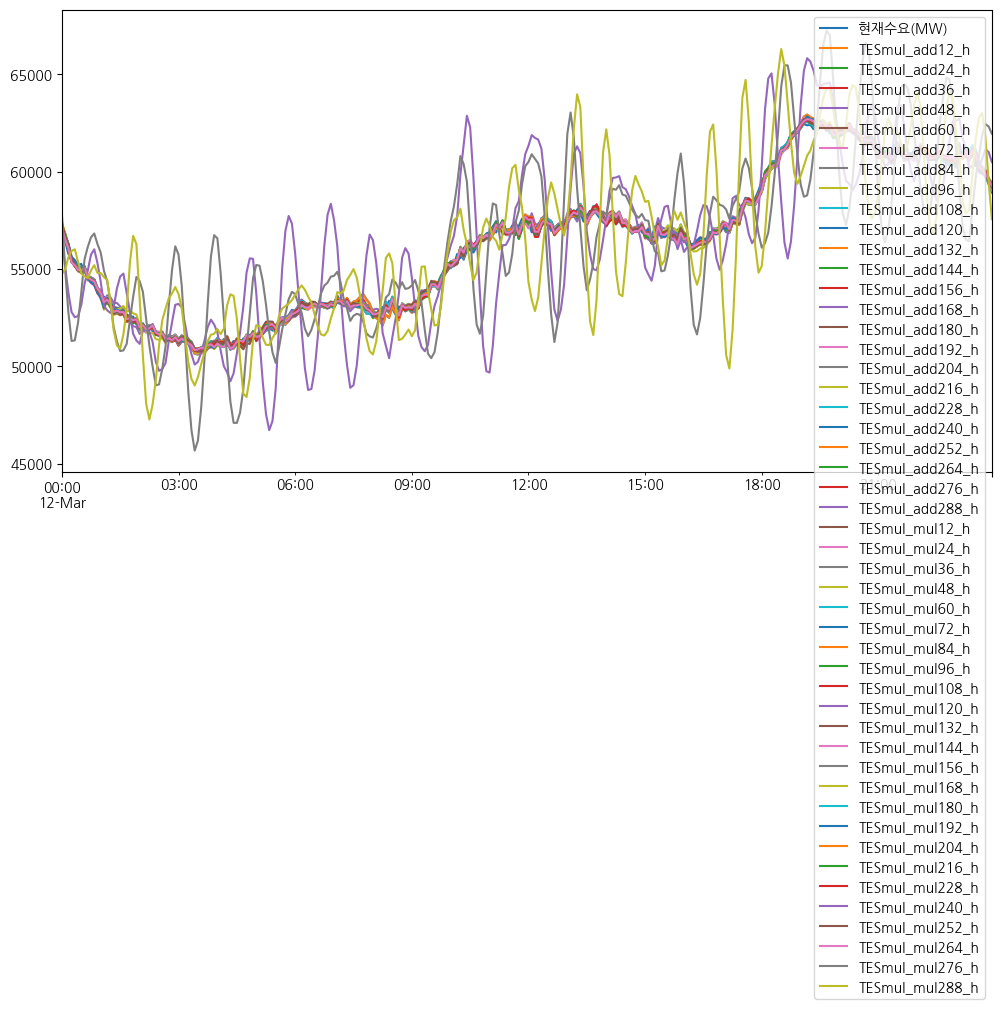

In [234]:
tes_tr_mul.iloc[-day:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### Grid Search

In [32]:
model_mul_mul = ExponentialSmoothing(tes_tr_mul['현재수요(MW)'], trend='mul', seasonal='mul',seasonal_periods=288).fit(optimized=True)
tes_tr_mul[f'TESmul_mul_grid'] = model_mul_mul.fittedvalues
model_mul_mul.params

C:\Users\ppjjh\anaconda3\envs\torch2\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{'smoothing_level': 0.9242857142857143,
 'smoothing_trend': 0.17116402116402116,
 'smoothing_seasonal': 0.010816326530612248,
 'damping_trend': nan,
 'initial_level': 63597.180202546275,
 'initial_trend': 0.9999894703733033,
 'initial_seasons': array([1.0206099 , 1.01855955, 1.01342831, 1.01079184, 1.00390147,
        0.99990618, 0.9951865 , 0.99112177, 0.9877795 , 0.98624115,
        0.98296543, 0.97792871, 0.97446482, 0.97820196, 0.97659078,
        0.97549693, 0.97149325, 0.9706871 , 0.96770493, 0.96426776,
        0.96107075, 0.95823461, 0.96066892, 0.96180897, 0.96126081,
        0.96012782, 0.96092893, 0.96228223, 0.95996782, 0.95914667,
        0.9578499 , 0.95642466, 0.9544563 , 0.95453623, 0.95217724,
        0.95118546, 0.95266978, 0.95241056, 0.95090758, 0.95239622,
        0.952929  , 0.95183544, 0.95181318, 0.95192136, 0.95174383,
        0.95244007, 0.95246377, 0.95524333, 0.95475418, 0.95523096,
        0.95288831, 0.95413348, 0.95698234, 0.95867216, 0.96288173,
        

DatetimeIndex(['2022-04-01 00:00:00', '2022-04-01 00:05:00',
               '2022-04-01 00:10:00', '2022-04-01 00:15:00',
               '2022-04-01 00:20:00', '2022-04-01 00:25:00',
               '2022-04-01 00:30:00', '2022-04-01 00:35:00',
               '2022-04-01 00:40:00', '2022-04-01 00:45:00',
               ...
               '2023-03-12 23:10:00', '2023-03-12 23:15:00',
               '2023-03-12 23:20:00', '2023-03-12 23:25:00',
               '2023-03-12 23:30:00', '2023-03-12 23:35:00',
               '2023-03-12 23:40:00', '2023-03-12 23:45:00',
               '2023-03-12 23:50:00', '2023-03-12 23:55:00'],
              dtype='datetime64[ns]', name='기준일시', length=99648, freq='5T')

MAPE of DESadd108_h_model.pkl: 32.8836%
MAPE of DESadd1152_model.pkl: 16.4090%
MAPE of DESadd120_h_model.pkl: 31.8511%
MAPE of DESadd12_h_model.pkl: 153.8742%
MAPE of DESadd132_h_model.pkl: 30.6899%
MAPE of DESadd1440_model.pkl: 12.8292%
MAPE of DESadd144_h_model.pkl: 29.4393%
MAPE of DESadd144_model.pkl: 29.4393%
MAPE of DESadd156_h_model.pkl: 28.1253%
MAPE of DESadd168_h_model.pkl: 26.7636%
MAPE of DESadd1728_model.pkl: 11.1317%
MAPE of DESadd180_h_model.pkl: 25.3694%
MAPE of DESadd192_h_model.pkl: 23.9543%
MAPE of DESadd2016_model.pkl: 10.4452%
MAPE of DESadd204_h_model.pkl: 20.2935%
MAPE of DESadd216_h_model.pkl: 14.8844%
MAPE of DESadd228_h_model.pkl: 11.9418%
MAPE of DESadd240_h_model.pkl: 10.5619%
MAPE of DESadd24_h_model.pkl: 123.1356%
MAPE of DESadd252_h_model.pkl: 10.9737%
MAPE of DESadd264_h_model.pkl: 12.5325%
MAPE of DESadd276_h_model.pkl: 12.8553%
MAPE of DESadd288_h_model.pkl: 12.6453%
MAPE of DESadd288_model.pkl: 12.6453%
MAPE of DESadd36_h_model.pkl: 65.0290%
MAPE of D

## Load Data - 재시작점

In [95]:
# sma_train.to_csv("meteorological/timeseries_data/sma_train_h.csv")
# ses_train.to_csv("meteorological/timeseries_data/ses_train_h.csv")
# des_train.to_csv("meteorological/timeseries_data/des_train_h.csv")
# tes_tr_add.to_csv("meteorological/timeseries_data/tes_tr_add_h.csv")
# tes_tr_mul.to_csv("meteorological/timeseries_data/tes_tr_mul_h.csv")

In [4]:
# 시계열데이터 import
sma_train = pd.read_csv("meteorological/timeseries_data/sma_train.csv",index_col=0, parse_dates=True)
sma_train.index.freq = '5T'
ses_train = pd.read_csv("meteorological/timeseries_data/ses_train.csv",index_col=0, parse_dates=True)
ses_train.index.freq = '5T'
des_train = pd.read_csv("meteorological/timeseries_data/des_train.csv",index_col=0, parse_dates=True)
des_train.index.freq = '5T'
tes_tr_add = pd.read_csv("meteorological/timeseries_data/tes_tr_add.csv",index_col=0, parse_dates=True)
tes_tr_add.index.freq = '5T'
tes_tr_mul = pd.read_csv("meteorological/timeseries_data/tes_tr_mul.csv",index_col=0, parse_dates=True)
tes_tr_mul.index.freq = '5T'
# 기상데이터 import
df_final = pd.read_csv("meteorological/df_final.csv", index_col=0, parse_dates=True) # 기상데이터 total 최종본
df_final.index.freq = '5T'
train = pd.read_csv("meteorological/train.csv", index_col=0, parse_dates=True) # 2022-04-01 00:00:00 ~ 2023-03-12 23:55:00 까지의 데이터
train.index.freq = '5T'
X_train = pd.read_csv("meteorological/X_train.csv", index_col=0, parse_dates=True)
X_train.index.freq='5T'
y_train = pd.read_csv("meteorological/y_train.csv", index_col=0, parse_dates=True)
y_train.index.freq='5T'
test = pd.read_csv("meteorological/test.csv", index_col=0, parse_dates=True) # 2023-03-13 00:00:00':'2023-03-19 23:55:00' 까지의 데이터
test.index.freq = '5T'
X_test = pd.read_csv("meteorological/X_test.csv", index_col=0, parse_dates=True)
X_test.index.freq = '5T'
y = pd.read_csv("meteorological/y.csv", index_col=0, parse_dates=True)
y.index.freq = '5T'
answer_list = pd.read_csv("meteorological/answer_list.csv", index_col=0, parse_dates=True)
answer_list.index.freq = '5T'
answer_list_h = pd.read_csv("meteorological/answer_list_h.csv", index_col=0, parse_dates=True)
answer_list_h.index.freq = '5T'

# Forecasting
SMA는 추세를 파악하기에 더 적절하므로 예측에 포함되지 않음

## SES, DES, TES

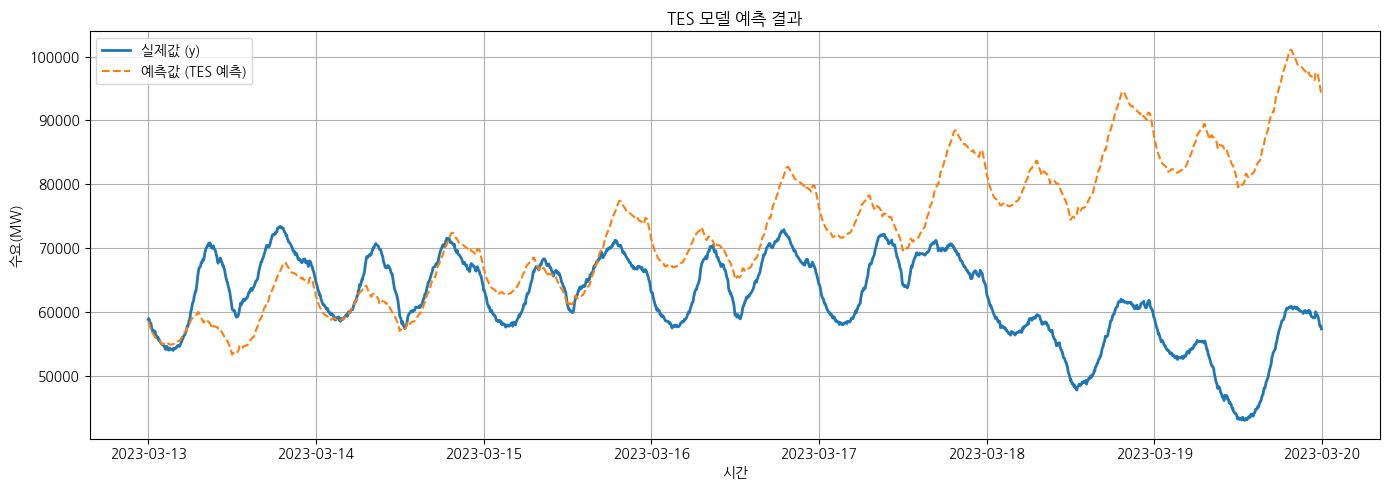

In [33]:
# 예측할 기간 길이 (answer_list_h와 동일한 길이)
n_forecast = len(answer_list_h)

# 1. forecast: 학습 이후 구간 예측
forecast_y = model_mul_mul.forecast(steps=n_forecast)

# 2. 결과 저장
answer_list_h["y_pred"] = forecast_y.values  # 또는 .to_numpy()

# 3. 시각화
plt.figure(figsize=(14, 5))
plt.plot(answer_list_h.index, answer_list_h["y"], label="실제값 (y)", linewidth=2)
plt.plot(answer_list_h.index, answer_list_h["y_pred"], label="예측값 (TES 예측)", linestyle="--")
plt.title("TES 모델 예측 결과")
plt.xlabel("시간")
plt.ylabel("수요(MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# 모델 파일이 저장된 디렉토리
model_dir = 'meteorological/model'

y_pred = {}  # 예측 값
under_15 = {}
# 디렉토리에 있는 모든 파일을 대상으로
for filename in os.listdir(model_dir):
    # '.pkl' 확장자인 파일만 처리
    if filename.endswith('.pkl'):
        # 파일을 불러옴
        with open(os.path.join(model_dir, filename), 'rb') as file:
            model = pickle.load(file)

        # 모델을 사용하여 값을 예측
        # 예측에 필요한 입력 데이터는 해당 모델에 따라 다를 수 있음
        prediction = model.forecast(2016).rename(f'{filename}')

        # 예측 값을 y_pred 리스트에 추가
        y_pred[filename] = prediction

        # 모델 이름과 MAPE 값을 출력
        mape_v = mape(y, prediction)
        print(f'MAPE of {filename}: {mape_v*100:.4f}%')
        if mape_v*100 <= 20 and filename[:3] == 'TES' :
            under_15[filename] = mape_v*100
        # mape_v = mean_absolute_error(y, y_pred) / (sum(y)/len(y)) * 100
        # print(f'MAPE of {filename}: {mape_v}%')

In [6]:
answer_list_h = pd.DataFrame(y_pred)

In [13]:
answer_list_h.to_csv("meteorological/answer_list_h.csv")

In [14]:
under_15

{'TESadd_mul576_model.pkl': 16.53172418305082,
 'TESmul_add156_h_model.pkl': 17.252235594643683,
 'TESmul_mul576_model.pkl': 19.47081070004824}

In [15]:
target_data = list(under_15.keys())

In [20]:
answer_list_h["y"] = y
answer_list["y"] = y

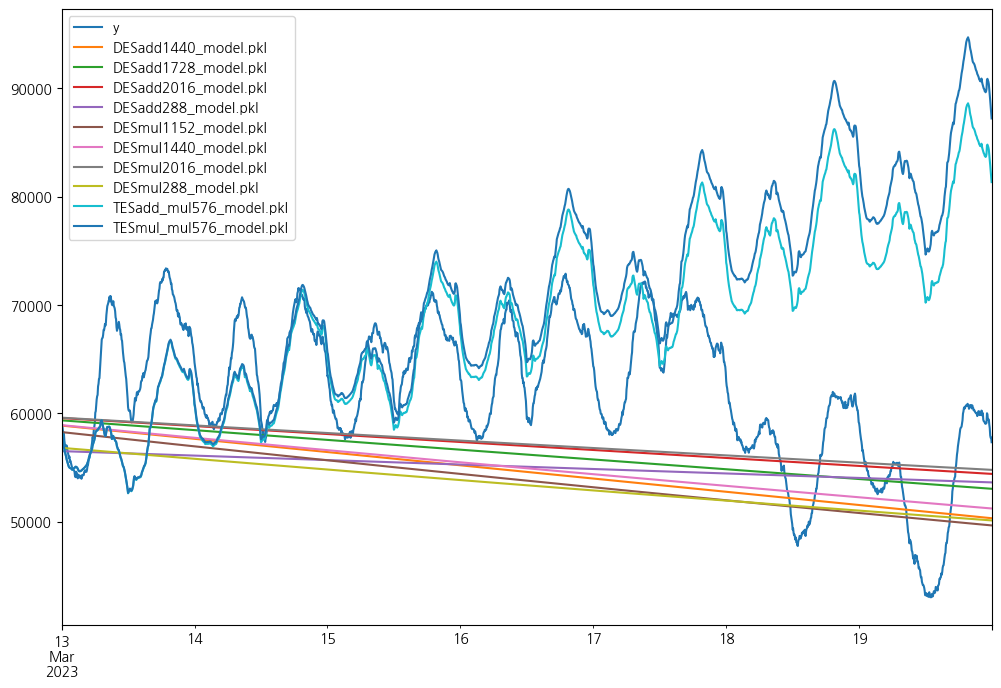

In [21]:
answer_list[["y",'DESadd1440_model.pkl', "DESadd1728_model.pkl", "DESadd2016_model.pkl","DESadd288_model.pkl", "DESmul1152_model.pkl", "DESmul1440_model.pkl", "DESmul2016_model.pkl", "DESmul288_model.pkl","TESadd_mul576_model.pkl", 'TESmul_mul576_model.pkl']].plot(figsize = (12,8));

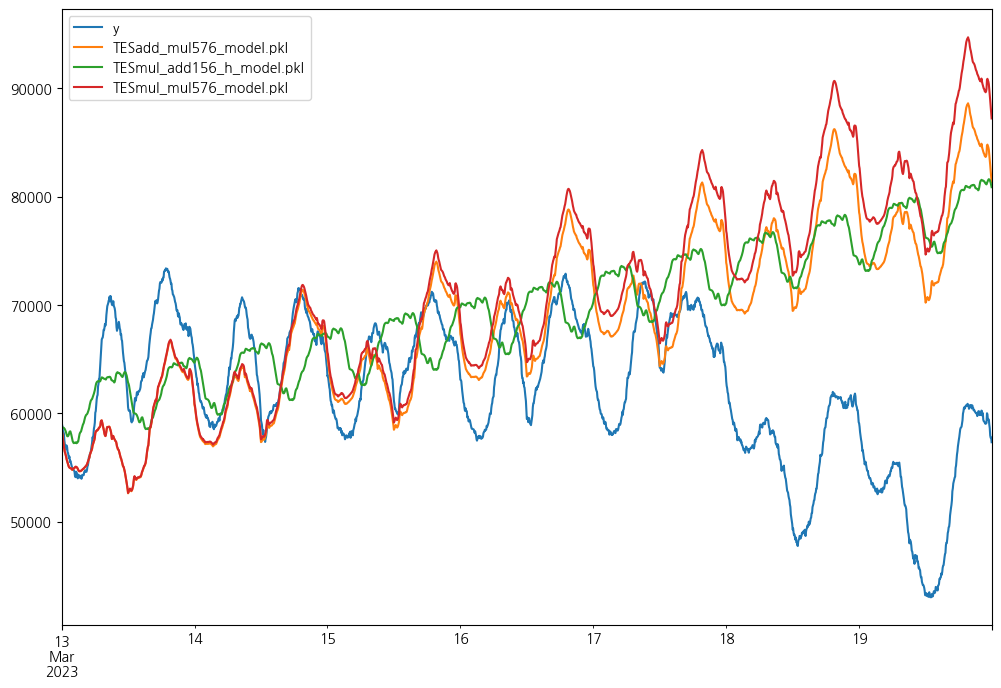

In [11]:
answer_list_h[["y",*target_data]].iloc[-2016:].plot(figsize = (12,8));

Seasonal이 포함된 가장 유효한 시점(13시간, 24시간 ,48시간)

In [109]:
# 가장 유효한 시점(13시간, 24시간 ,48시간)
TES_features = [156, 288, 576]

[[156, 288, 576], [25, 68], [156, 288, 576]]

## ARMA, ARIMA (Drop - 시스템 자원의 한계로 분석 불가)
다차항

In [ ]:

# 모델 파일이 저장된 디렉토리
model_dir = 'meteorological/model/arima'
start = len(train)
end = len(df_final)
y_pred = {}  # 예측 값
under_20 = {}
# 디렉토리에 있는 모든 파일을 대상으로
for filename in os.listdir(model_dir):
    # '.pkl' 확장자인 파일만 처리
    if filename.endswith('.pkl'):
        # 파일을 불러옴
        with open(os.path.join(model_dir, filename), 'rb') as file:
            model = pickle.load(file)

        # 모델을 사용하여 값을 예측
        # 예측에 필요한 입력 데이터는 해당 모델에 따라 다를 수 있음
        prediction = model.predict(2016).rename(f'{filename}')

        # 예측 값을 y_pred 리스트에 추가
        y_pred[filename] = prediction

        # 모델 이름과 MAPE 값을 출력
        mape_v = mape(y, prediction)
        print(f'MAPE of {filename}: {mape_v*100:.4f}%')
        if mape_v*100 <= 20 and filename[:3] == 'TES' :
            under_15[filename] = mape_v*100
        # mape_v = mean_absolute_error(y, y_pred) / (sum(y)/len(y)) * 100
        # print(f'MAPE of {filename}: {mape_v}%')

MAPE of arima_mod.pkl: 14.1278%


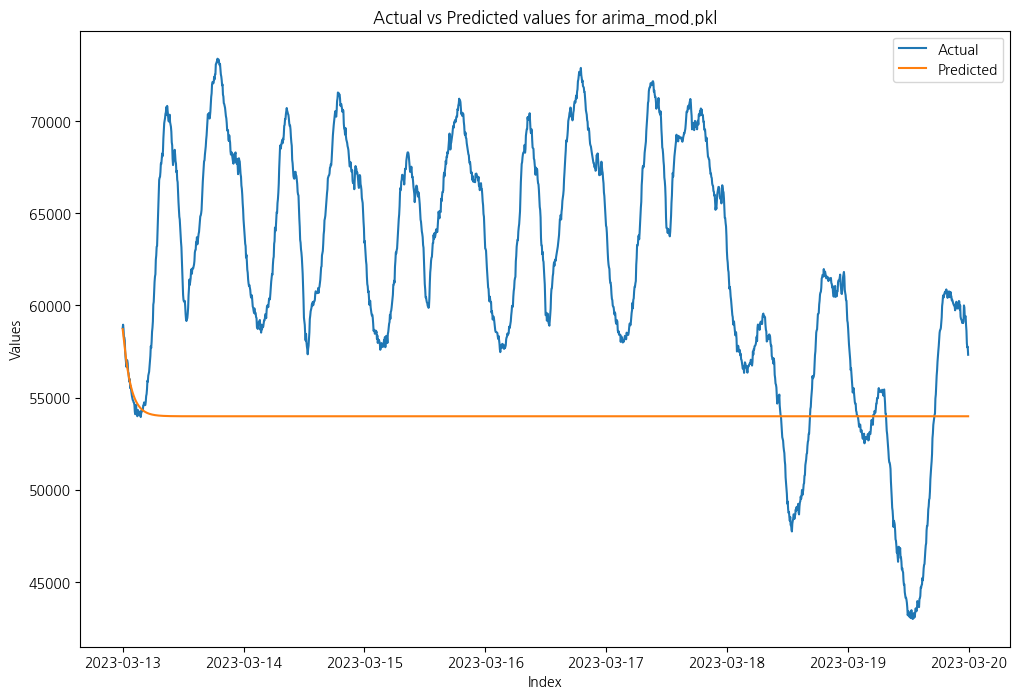

MAPE of arma_model_108.pkl: 14.1278%


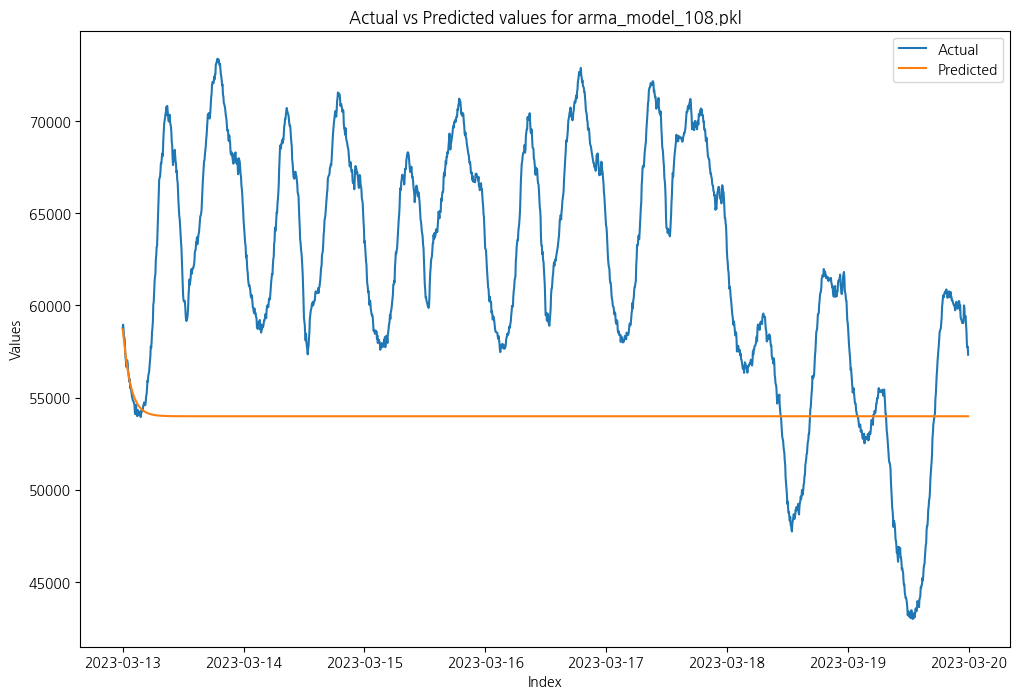

MAPE of arma_model_1152.pkl: 14.1278%


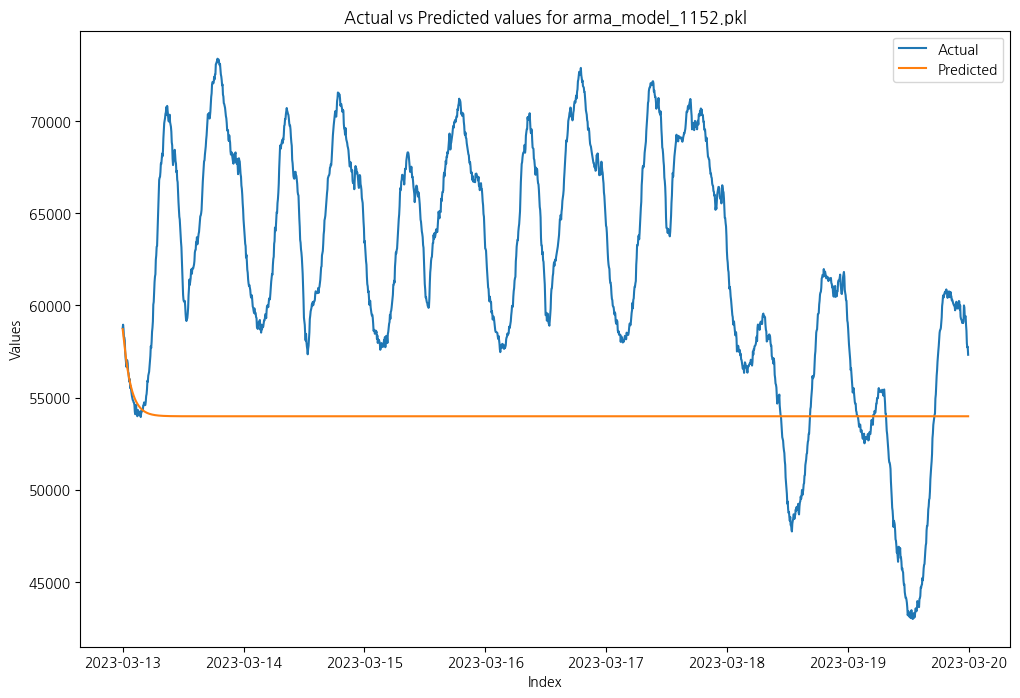

MAPE of arma_model_12.pkl: 14.1278%


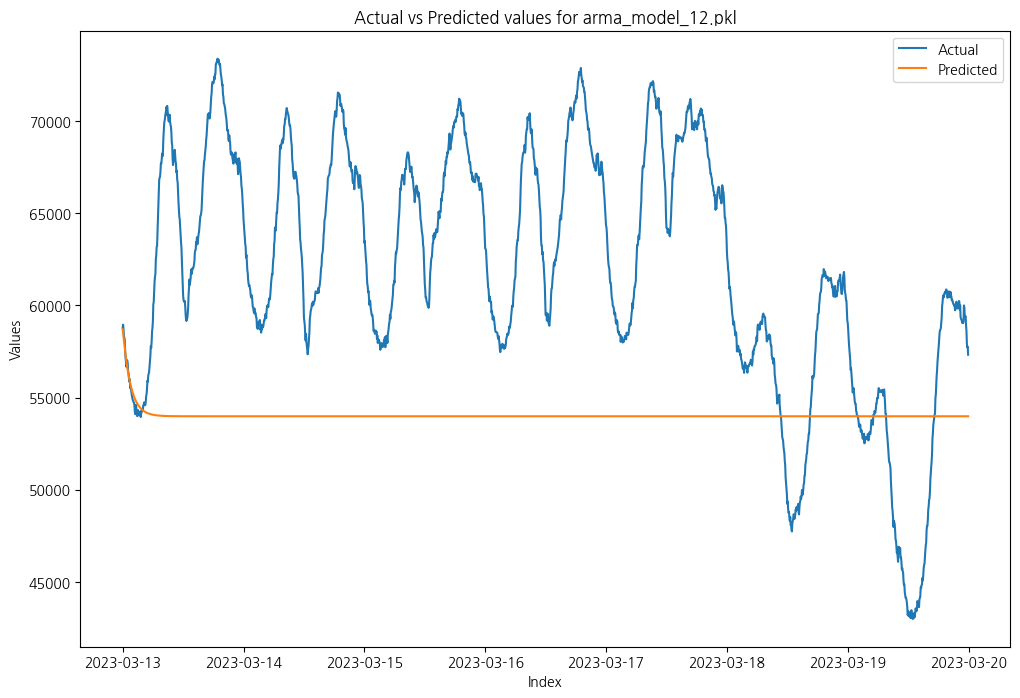

MAPE of arma_model_120.pkl: 14.1278%


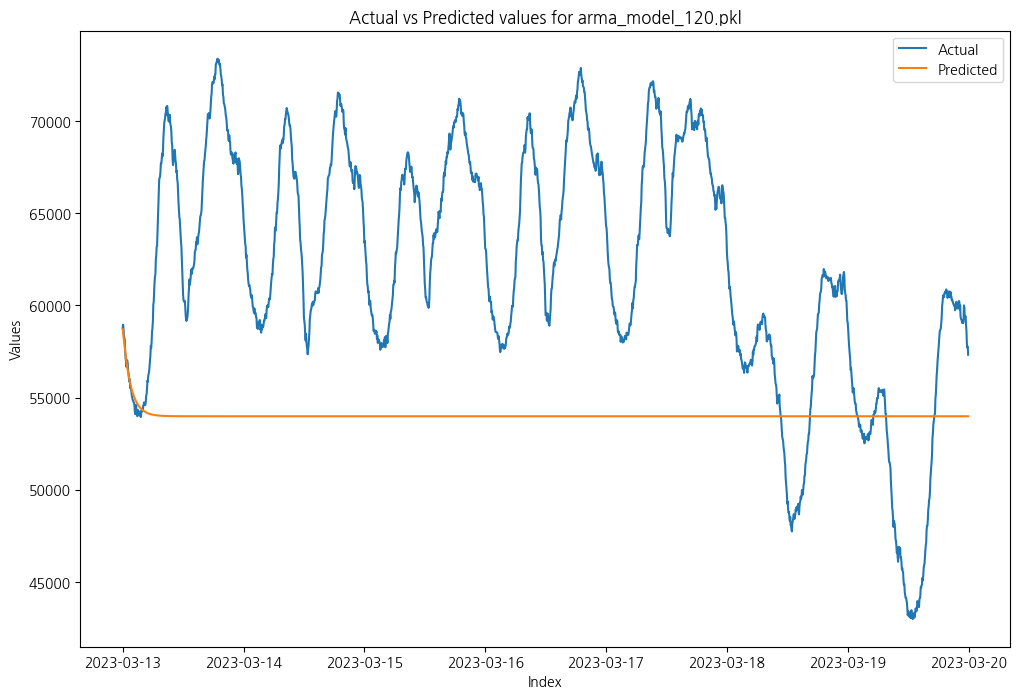

MAPE of arma_model_132.pkl: 14.1278%



KeyboardInterrupt



In [4]:
import matplotlib.pyplot as plt

# 모델 파일이 저장된 디렉토리
model_dir = 'meteorological/model/arima'
start = len(train)
end = len(df_final)
y_pred = {}  # 예측 값
under_20 = {}

# 디렉토리에 있는 모든 파일을 대상으로
for filename in os.listdir(model_dir):
    # '.pkl' 확장자인 파일만 처리
    if filename.endswith('.pkl'):
        # 파일을 불러옴
        with open(os.path.join(model_dir, filename), 'rb') as file:
            model = pickle.load(file)

        # 모델을 사용하여 값을 예측
        # 예측에 필요한 입력 데이터는 해당 모델에 따라 다를 수 있음
        prediction = model.predict(2016).rename(f'{filename}')

        # 예측 값을 y_pred 리스트에 추가
        y_pred[filename] = prediction

        # 모델 이름과 MAPE 값을 출력
        mape_v = mape(y, prediction)
        print(f'MAPE of {filename}: {mape_v*100:.4f}%')
        if mape_v*100 <= 20 and filename[:3] == 'TES' :
            under_20[filename] = mape_v*100

        # Plotting the actual vs predicted values
        plt.figure(figsize=(12, 8))
        plt.plot(y, label='Actual')
        plt.plot(prediction, label='Predicted')
        plt.title(f'Actual vs Predicted values for {filename}')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()


In [218]:
features = [acf_pacf_features,adf_features, TES_features]
features

[[156, 288, 576], [25, 68], [156, 288, 576]]

### SARIMA

In [24]:
temp = [25, 68, 144, 156, 288, 576, 864, 1152, 1440, 1728, 2016]

## Prophet

In [34]:
from prophet import Prophet
from prophet.plot import plot

In [35]:
y_train = y_train.reset_index()


In [36]:
y_train.rename(columns={'index' : 'ds', "현재수요(MW)": "y"}, inplace=True)

In [37]:
y_train

ds         y
0     2022-04-01 00:00:00  62453.29
1     2022-04-01 00:05:00  62329.25
2     2022-04-01 00:10:00  61830.96
3     2022-04-01 00:15:00  61648.72
4     2022-04-01 00:20:00  61382.62
...                   ...       ...
99643 2023-03-12 23:35:00  60235.18
99644 2023-03-12 23:40:00  60106.61
99645 2023-03-12 23:45:00  59725.49
99646 2023-03-12 23:50:00  59485.58
99647 2023-03-12 23:55:00  58929.88

[99648 rows x 2 columns]

In [40]:
m = Prophet()
m.fit(y_train)

21:42:11 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# df.index.freq = ""
future = m.make_future_dataframe(periods= 2016, freq = '5T')

In [42]:
len(future)

101664

In [43]:
len(y_train)

99648

In [26]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds          yhat    yhat_lower    yhat_upper
101659 2023-03-19 23:35:00  56595.152967  50486.932276  62783.582445
101660 2023-03-19 23:40:00  56433.034211  50350.255476  61901.866240
101661 2023-03-19 23:45:00  56271.981727  50887.056877  62201.850919
101662 2023-03-19 23:50:00  56112.204161  50261.484333  61656.268291
101663 2023-03-19 23:55:00  55953.902731  49932.920169  62090.863229

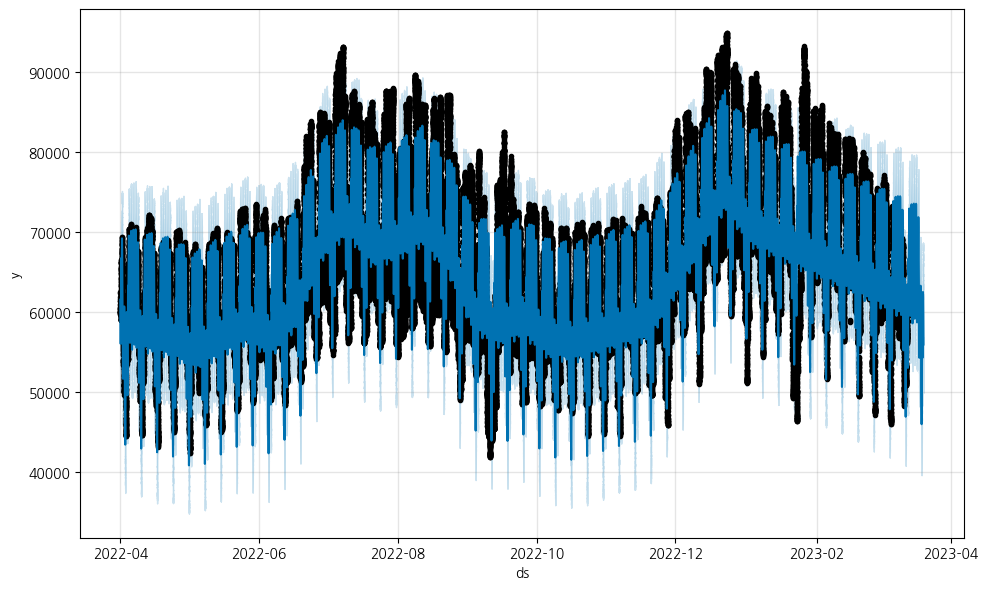

In [27]:
fig1 = m.plot(forecast)

In [28]:
date_range_forecast = forecast[(forecast['ds'] >= '2023-03-12') & (forecast['ds'] <= '2023-03-22')]

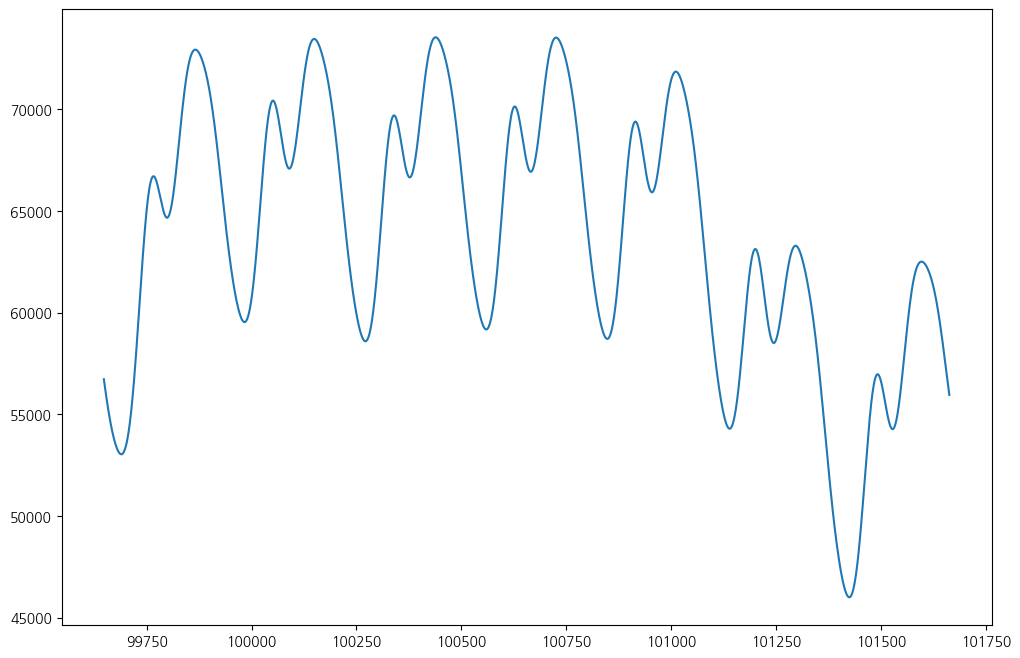

In [29]:
forecast.loc[99648:,"yhat"].plot(figsize = (12,8));

In [30]:
y.reset_index(inplace=True)
y.rename(columns={'index': 'ds', '현재수요(MW)':'y'}, inplace=True)

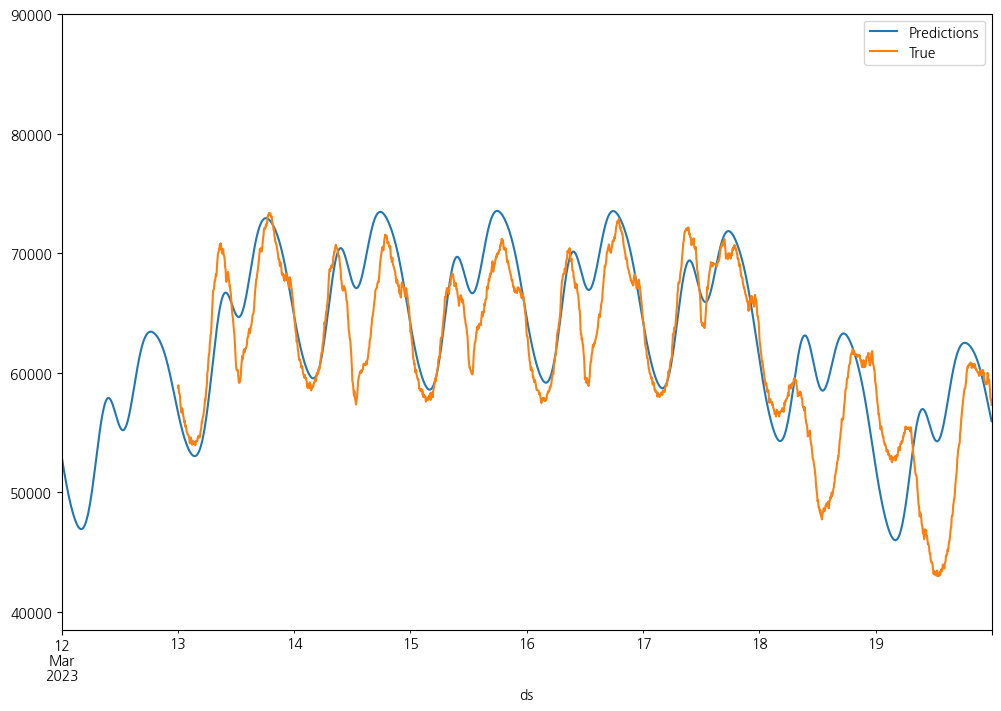

In [31]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

y.plot(x='ds',y='y',label='True',legend=True,ax=ax,xlim=('2023-03-12 00:00:00','2023-03-19 23:55:00'));

In [32]:
prediction = forecast.loc[99648:,'yhat']

In [33]:
mape_v = mape(y['y'], prediction)
print(f'MAPE : {mape_v*100:.4f}%')


MAPE : 5.7712%


### Prophet(기상변수, seasonality 추가)

In [ ]:

'''
추가 가능한 변수들
train_df.rename(columns={"num_date_time" : "num_date_time", "건물번호":"b_num", "일시" : "D&T", "기온(C)" : "temp", "강수량(mm)" : "precip", "풍속(m/s)" : "w_s" , "습도(%)" : "hum", "일조(hr)" : "일조(hr)", "일사(MJ/m2)" : "일사(MJ/m2)", "전력소비량(kWh)":"power", "건물유형":"b_type", "연면적(m2)":"f_area", "냉방면적(m2)":"c_area", "태양광용량(kW)": "SUN_light", "ESS저장용량(kWh)": "ESS_save", "PCS용량(kW)":"PCS" }, inplace=True)
test_df.rename(columns={"num_date_time" : "num_date_time", "건물번호":"b_num", "일시" : "D&T", "기온(C)" : "temp", "강수량(mm)" : "precip", "풍속(m/s)" : "w_s" , "습도(%)" : "hum", "일조(hr)" : "일조(hr)", "일사(MJ/m2)" : "일사(MJ/m2)", "전력소비량(kWh)":"power", "건물유형":"b_type", "연면적(m2)":"f_area", "냉방면적(m2)":"c_area", "태양광용량(kW)": "SUN_light", "ESS저장용량(kWh)": "ESS_save", "PCS용량(kW)":"PCS"} , inplace= True)
# def CDH(xs):
#     ys = []
#     for i in range(len(xs)):
#         if i < 11:
#             ys.append(np.sum(xs[:(i+1)]-26))
#         else:
#             ys.append(np.sum(xs[(i-11):(i+1)]-26))
#     return np.array(ys)
def is_weekend(ds):
    date = pd.to_datetime(ds)
    if date.weekday() >= 5:
        return 1
    else:
        return 0
def is_noon(ds):
    date = pd.to_datetime(ds)
    if date.hour >= 7 and date.hour<20:
        return 1
    else:
        return 0
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
def make_data(train_df):
    # 선형보간 실시
    train_df["w_s"] = train_df["w_s"].interpolate()
    train_df["hum"] = train_df["hum"].interpolate()
    # 소수점 단위 절삭
    train_df["c_area"] = train_df["c_area"].round(4)
    train_df["f_area"] = train_df["f_area"].round(4)
    # 레이블 인코딩
    lf1 = LabelEncoder()
    train_df["c_area"] = lf1.fit_transform(train_df["c_area"])
    lf2= LabelEncoder()
    train_df["f_area"] = lf2.fit_transform(train_df["f_area"])
    lf3 = LabelEncoder()
    train_df["b_type"] = lf3.fit_transform(train_df["b_type"])

    # 파생변수 생성 (train data)
    train_df['D&T'] = pd.to_datetime(train_df['D&T'])
    train_df['hour'] = train_df['D&T'].dt.hour
    train_df['sin_time'] = np.sin(2*np.pi*train_df.hour/24)
    train_df['cos_time'] = np.cos(2*np.pi*train_df.hour/24)
    train_df['day'] = train_df['D&T'].dt.weekday
    train_df['weekend'] = train_df['day'].isin([5,6]).astype(int)
    train_df['month'] = train_df['D&T'].dt.month
    train_df['THI'] = 9/5*train_df['temp'] - 0.55*(1-train_df['hum']/100)*(9/5*train_df['temp']-26)+32
    train_df['weekend'] = train_df['D&T'].apply(is_weekend)
    train_df['noon'] = train_df['D&T'].apply(is_noon)
    cdhs = np.array([])
    for num in range(1,101,1):
        temp = train_df[train_df['b_num'] == num]
        cdh = CDH(temp['temp'].values)
        cdhs = np.concatenate([cdhs, cdh])
    if "power" in train_df.columns:
        train_df['CDH'] = cdhs
        train_df.drop("num_date_time", axis =1 , inplace=True)
        # K-Means > train data
        by_day = train_df.groupby(['b_num','day'])['power'].median().reset_index().pivot('b_num','day','power').reset_index()
        by_hour = train_df.groupby(['b_num','hour'])['power'].median().reset_index().pivot('b_num','hour','power').reset_index().drop('b_num', axis = 1)
        df = pd.concat([by_day, by_hour], axis= 1)
        columns = ['b_num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
        df.columns = columns
        kmeans = KMeans(n_clusters=5, random_state = 42)
        km_cluster = kmeans.fit_predict(df.iloc[:,1:])

        df_clust = df.copy()
        df_clust['km_cluster'] = km_cluster
        # df_clust['km_cluster'] = df_clust['km_cluster'].map({})

        train_df = train_df.merge(df_clust[['b_num','km_cluster']], on='b_num', how='left')
        km_d = pd.get_dummies(train_df['km_cluster'], prefix='km', drop_first=False)

        train_df = pd.concat([train_df, km_d], axis=1)
            # prophet 형태로 전환
        train_df.rename(columns={"D&T": "ds", "power": "y"}, inplace=True)
        train_df = train_df.fillna(0)
        return train_df, df_clust


    else :
        pass

    return train_df
    '''

In [69]:
from prophet import Prophet

# ───────────────────────────────
# 1. Prophet 모델 생성
# ───────────────────────────────
m = Prophet()

# # ───────────────────────────────
# # 2. 외생 변수(기상 정보) 등록
# # ───────────────────────────────
# m.add_regressor('이슬점온도')
# m.add_regressor('기온')
# m.add_regressor('상대습도')
# m.add_regressor('강수량')
# m.add_regressor('일조량')
# m.add_regressor('지면온도')
# m.add_regressor('풍속')
# m.add_regressor('기압')
# m.add_regressor('시정(가시거리)')
# 
# # ───────────────────────────────
# # 3. 모델 학습
# # ───────────────────────────────
# m.fit(train)


21:59:07 - cmdstanpy - INFO - Chain [1] start processing
22:00:07 - cmdstanpy - INFO - Chain [1] done processing


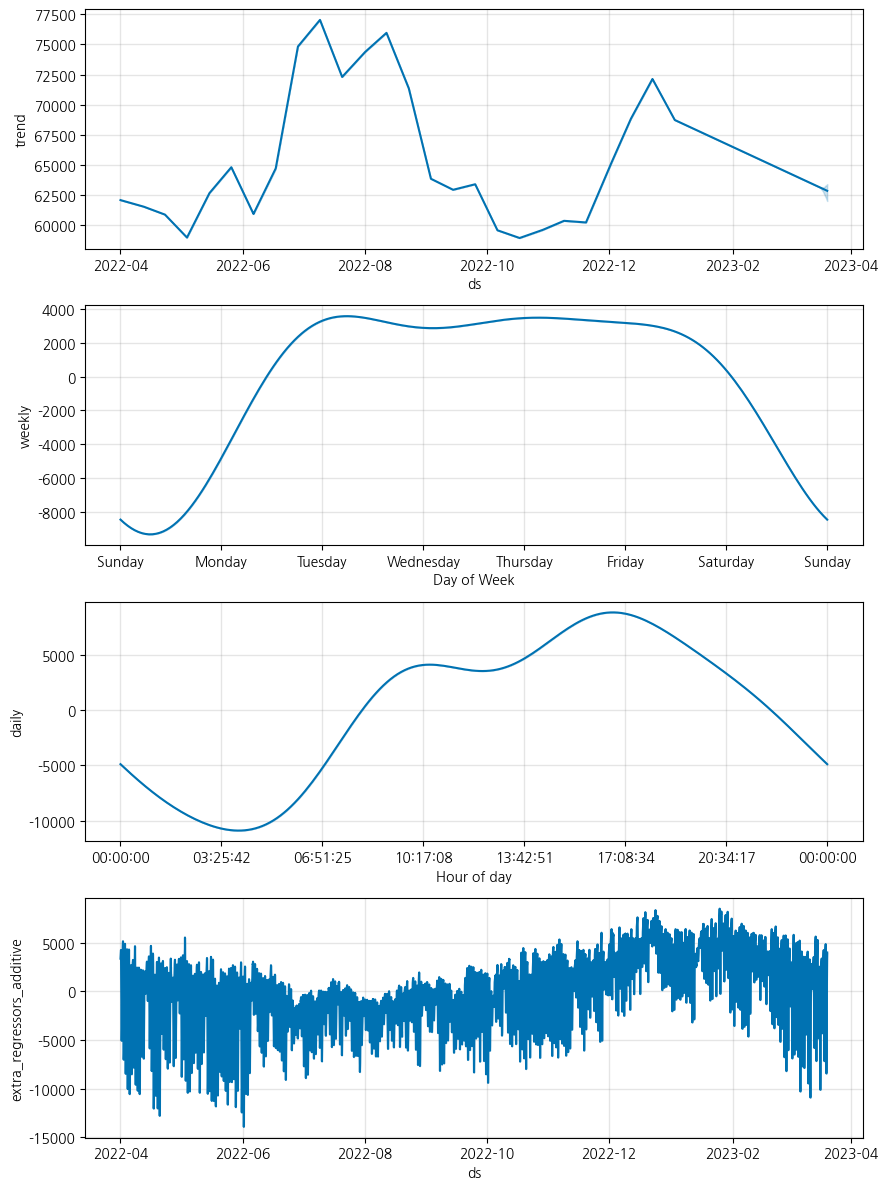

In [70]:
# 시계열데이터 import
sma_train = pd.read_csv("meteorological/timeseries_data/sma_train.csv",index_col=0, parse_dates=True)
sma_train.index.freq = '5T'
ses_train = pd.read_csv("meteorological/timeseries_data/ses_train.csv",index_col=0, parse_dates=True)
ses_train.index.freq = '5T'
des_train = pd.read_csv("meteorological/timeseries_data/des_train.csv",index_col=0, parse_dates=True)
des_train.index.freq = '5T'
tes_tr_add = pd.read_csv("meteorological/timeseries_data/tes_tr_add.csv",index_col=0, parse_dates=True)
tes_tr_add.index.freq = '5T'
tes_tr_mul = pd.read_csv("meteorological/timeseries_data/tes_tr_mul.csv",index_col=0, parse_dates=True)
tes_tr_mul.index.freq = '5T'
# 기상데이터 import
df_final = pd.read_csv("meteorological/df_final.csv", index_col=0, parse_dates=True) # 기상데이터 total 최종본
df_final.index.freq = '5T'
train = pd.read_csv("meteorological/train.csv", index_col=0, parse_dates=True) # 2022-04-01 00:00:00 ~ 2023-03-12 23:55:00 까지의 데이터
train.index.freq = '5T'
X_train = pd.read_csv("meteorological/X_train.csv", index_col=0, parse_dates=True)
X_train.index.freq='5T'
y_train = pd.read_csv("meteorological/y_train.csv", index_col=0, parse_dates=True)
y_train.index.freq='5T'
test = pd.read_csv("meteorological/test.csv", index_col=0, parse_dates=True) # 2023-03-13 00:00:00':'2023-03-19 23:55:00' 까지의 데이터
test.index.freq = '5T'
X_test = pd.read_csv("meteorological/X_test.csv", index_col=0, parse_dates=True)
X_test.index.freq = '5T'
y = pd.read_csv("meteorological/y.csv", index_col=0, parse_dates=True)
y.index.freq = '5T'
df_final.reset_index(inplace=True)

train.reset_index(inplace=True)
y.reset_index(inplace=True)
train = train.rename(columns={"index" : "ds", "현재수요(MW)": "y"})
y = y.rename(columns={"index" : "ds", "현재수요(MW)": "y"})
X_test.reset_index(inplace=True)
X_test = X_test.rename(columns={"index" : "ds", "현재수요(MW)": "y"})

m.add_regressor('이슬점온도')
m.add_regressor('기온')
m.add_regressor('상대습도')
m.add_regressor('강수량')
m.add_regressor('일조량')
m.add_regressor('지면온도')
m.add_regressor('풍속')
m.add_regressor('기압')
m.add_regressor('시정(가시거리)')
m.fit(train)
future = m.make_future_dataframe(periods=2016, freq='5T')
future["이슬점온도"] = df_final["이슬점온도"]
future["기온"] = df_final["기온"]
future["상대습도"] = df_final["상대습도"]
future["강수량"] = df_final["강수량"]
future["일조량"] = df_final["일조량"]
future["지면온도"] = df_final["지면온도"]
future["풍속"] = df_final["풍속"]
future["기압"] = df_final["기압"]
future["시정(가시거리)"] = df_final["시정(가시거리)"]
# future
forecast = m.predict(future)

# y_train = y_train.reset_index()
#
# y_train.rename(columns={'index': 'ds', "현재수요(MW)": "y"}, inplace=True)
# y_train
# m = Prophet()
# m.fit(y_train)
# # df.index.freq = ""
# future = m.make_future_dataframe(periods=2016, freq='5T')
# len(future)
# len(y_train)
# forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig = m.plot_components(forecast)

In [71]:
mape_v = mape(y['y'], forecast['yhat'][-2016:].reset_index(drop=True))
print(f'MAPE : {mape_v*100:.4f}')

MAPE : 4.5928


In [72]:
y['y']

0       58782.03
1       58954.44
2       58710.58
3       58298.44
4       58263.70
          ...   
2011    58627.16
2012    57941.24
2013    57726.21
2014    57755.40
2015    57323.79
Name: y, Length: 2016, dtype: float64

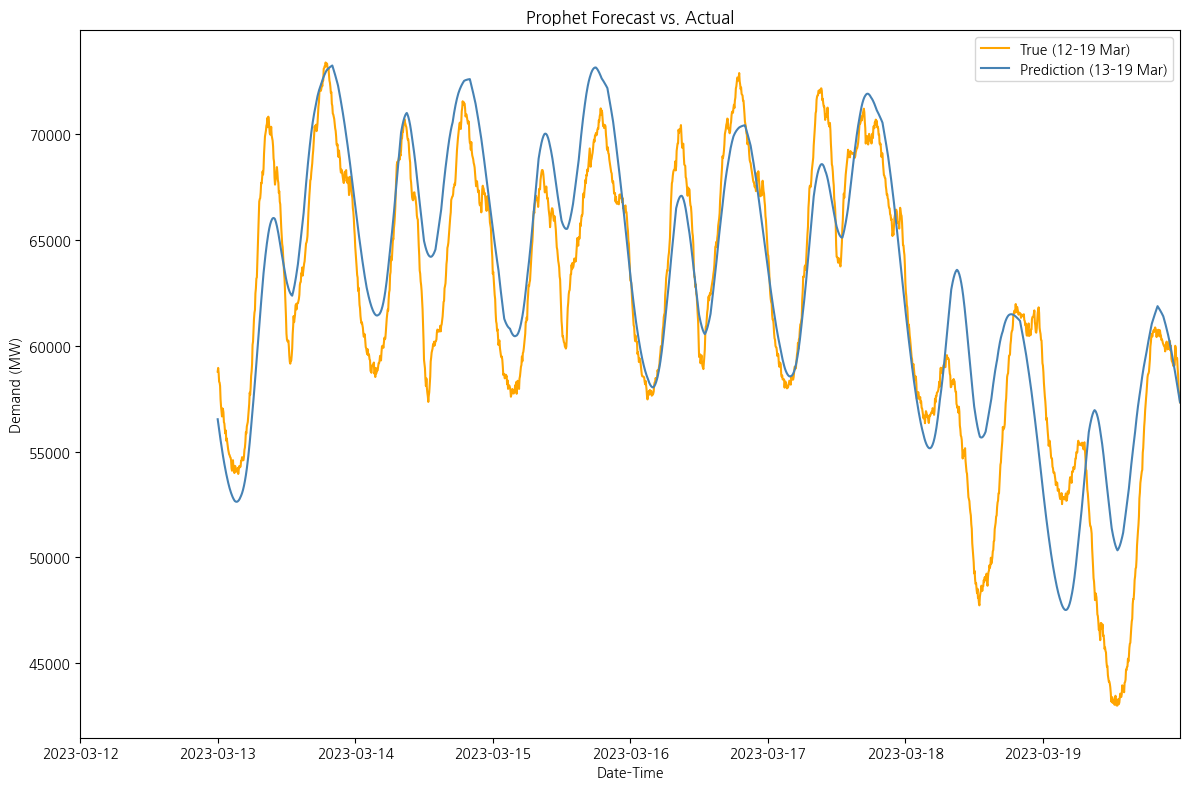

MAPE : 4.5928%


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

# ───────────────────────────────
# 1. 공통 설정
# ───────────────────────────────
start_true  = '2023-03-12 00:00:00'   # True 데이터는 12일 00:00부터
start_pred  = '2023-03-13 00:00:00'   # 예측은 13일 00:00부터
end_date    = '2023-03-19 23:55:00'

forecast['ds'] = pd.to_datetime(forecast['ds'])
y['ds']        = pd.to_datetime(y['ds'])

# ───────────────────────────────
# 2. 슬라이스
# ───────────────────────────────
y_slice       = y.loc[(y['ds'] >= start_true) & (y['ds'] <= end_date), ['ds', 'y']]
forecast_slice = forecast.loc[(forecast['ds'] >= start_pred) & (forecast['ds'] <= end_date),
                              ['ds', 'yhat']]

# ───────────────────────────────
# 3. 그래프
# ───────────────────────────────
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(y_slice['ds'],         y_slice['y'],    label='True (12–19 Mar)', color='orange')
ax.plot(forecast_slice['ds'], forecast_slice['yhat'], label='Prediction (13–19 Mar)', color='steelblue')

ax.set_xlim(pd.Timestamp(start_true), pd.Timestamp(end_date))
ax.set_xlabel('Date–Time')
ax.set_ylabel('Demand (MW)')
ax.set_title('Prophet Forecast vs. Actual')
ax.legend()
plt.tight_layout()
plt.show()

# ───────────────────────────────
# 4. MAPE (겹치는 구간만)
# ───────────────────────────────
merge_df = forecast_slice.merge(y_slice, on='ds', how='inner')
print(f"MAPE : {mape(merge_df['y'], merge_df['yhat'])*100:.4f}%")


# recap
5분단위 데이터의 25, 68, 156, 288, 576 step이 유효한 변수로 관찰됨.

future["이슬점온도"] = df_final["이슬점온도"]

future["기온"] = df_final["기온"]

future["상대습도"] = df_final["상대습도"]

future["강수량"] = df_final["강수량"]

future["일조량"] = df_final["일조량"]

future["지면온도"] = df_final["지면온도"]

future["풍속"] = df_final["풍속"]

future["기압"] = df_final["기압"]

future["시정(가시거리)"] = df_final["시정(가시거리)"]

이슬점온도, 기온, 상대습도, 강수량, 일조량, 지면온도, 풍속, 기압, 시정(가시거리)를 외생변수로 삽입한 결과 
MAPE는 1.1778상승해 4.5934를 달성할 수 있었음.

seasonal, 퓨리에 변수, 기상 파생변수를 사용했으나 성능향상엔 도움이 되지 않음.